# Example `Dysmalpy` 1D fitting

**Includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

## Setup steps

**Import modules**

In [1]:
# Import modules
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import dysmalpy
from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes
from dysmalpy import observation
from dysmalpy import config

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

In [2]:
# A check for compatibility:
import emcee
if np.int(emcee.__version__[0]) >= 3:
    ftype_sampler = 'h5'
else:
    ftype_sampler = 'pickle' 

**Setup notebook**

In [3]:
# Jupyter notebook setup
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

from IPython.core.display import Image

In [4]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

In [5]:
dysmalpy.__path__

['/Users/sedona/software_public/dysmalpy/dysmalpy']

**Set data, output paths**

In [6]:
# Data directory
dir_path = os.path.abspath(dysmalpy.__path__[0])
data_dir = os.sep.join([os.sep.join(dir_path.split(os.sep)[:-1]),'tests', 'test_data', ''])
#'/YOUR/DATA/PATH/'
data_dir                                  

'/Users/sedona/software_public/dysmalpy/tests/test_data/'

In [7]:
# Where to save output files
# outdir = '/Users/ttshimiz/test_dysmalpy_v2/'
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/'

-------------------

**Load the functions to tie parameters together**

In [8]:
# Tie the z height to the effective radius
from dysmalpy.fitting_wrappers.tied_functions import tie_sigz_reff

In [9]:
# Tie the halo mass to the dark matter fraction
from dysmalpy.fitting_wrappers.tied_functions import tie_lmvirial_NFW

:::{admonition} Info
Also see **fitting_wrappers.tied_functions** for more tied functions
:::

----------

## Initialize galaxy, model set, instrument

In [10]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()

### Baryonic component: Combined Disk+Bulge

In [11]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [12]:
mvirial = 12.0
conc = 5.0
fdm = 0.5

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile

In [13]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof', tracer='halpha')

### z-height profile

In [14]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [15]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': True,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, 
                       name='geom', obs_name='halpha_1D')

### Add all model components to ModelSet

In [16]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile

In [17]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the observation and instrument

In [18]:
obs = observation.Observation(name='halpha_1D', tracer='halpha')
inst = instrument.Instrument()

beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Extraction information
inst.ndim = 1                            # Dimensionality of data
inst.moment = False                      # For 1D/2D data, if True then velocities and dispersion calculated from moments
                                         # Default is False, meaning Gaussian extraction used

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

# Add instrument to observation
obs.instrument = inst

### Load data

* Load the data from file:
  - *1D velocity, dispersion profiles and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data1D` class

* Add data to Galaxy object

In [19]:
f_data_1d = data_dir+'GS4_43501.obs_prof.txt'
dat_arr = np.loadtxt(f_data_1d)
gs4_r = dat_arr[:,0]
gs4_vel = dat_arr[:,1]
gs4_disp = dat_arr[:,3]
err_vel = dat_arr[:,2]
err_disp = dat_arr[:,4]
inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data1D data class: 
data1d = data_classes.Data1D(r=gs4_r, velocity=gs4_vel,
                                  vel_disp=gs4_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, inst_corr=inst_corr, 
                                  filename_velocity=f_data_1d)

# Add data to Observation:
obs.data = data1d

### Setup apertures:

In [20]:
# Setup apertures: circular apertures placed on the cube for GS4_43501.

profile1d_type = 'circ_ap_cube'    # Extraction in circular apertures placed on the cube

aperture_radius = 0.5 * obs.instrument.beam.major.value

obs.instrument.apertures = aperture_classes.setup_aperture_types(obs=obs, 
                profile1d_type=profile1d_type, 
                aper_centers=obs.data.rarr,
                slit_pa=pa, slit_width=beamsize.value,
                aperture_radius=aperture_radius, 
                partial_weight=True)

### Define model, fit options:

In [21]:
obs.mod_options.oversample = 1  
# Factor by which to oversample model (eg, subpixels)

obs.fit_options.fit = True             # Include this observation in the fit (T/F)
obs.fit_options.fit_velocity = True    # 1D/2D: Fit velocity of observation (T/F)
obs.fit_options.fit_dispersion = True  # 1D/2D: Fit dispersion of observation (T/F)
obs.fit_options.fit_flux = False       # 1D/2D: Fit flux of observation (T/F)

### Add the model set, observation to the Galaxy

In [22]:
gal.model = mod_set
gal.add_observation(obs)

-----------------

## MPFIT Fitting

**Set up ``MPFITFitter`` fitter with fitting parameters**

In [23]:
# Options passed to MPFIT:
maxiter = 200

fitter = fitting.MPFITFitter(maxiter=maxiter)

**Set up fit/plot output options**

In [24]:
# Output directory
outdir_mpfit = outdir+'MPFIT/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mpfit, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MPFIT**

In [25]:
mpfit_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:    obs: halpha_1D
INFO:DysmalPy:        velocity file: /Users/sedona/software_public/dysmalpy/tests/test_data/GS4_43501.obs_prof.txt
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1349a97e0>
INFO:DysmalPy:
MPFIT Fitting:
Start: 2022-05-26 23:39:04.901998

INFO:DysmalPy:Iter 1  CHI-SQUARE = 1335.14675  DOF = 32
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 5  
   halo:fdm = 0.5  
   dispprof:sigma0 = 39  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 92.49188427  DOF = 32
   disk+bulge:total_mass = 10.73755804  
   disk+bulge:r_eff_disk = 3.192594339  
   halo:fdm = 0.3338434194  
   dispprof:sigma0 = 45.13011049  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 60.37548336  DOF = 32
   disk+bulge:total_mass = 10.68463852  
   disk+bulge:r_eff_disk = 2.96100708  
   halo:fdm = 0.2933931791  
   dispprof:sigma0 = 39.37983081  

INFO:Dys

### Examine MPFIT results

#### Result plots

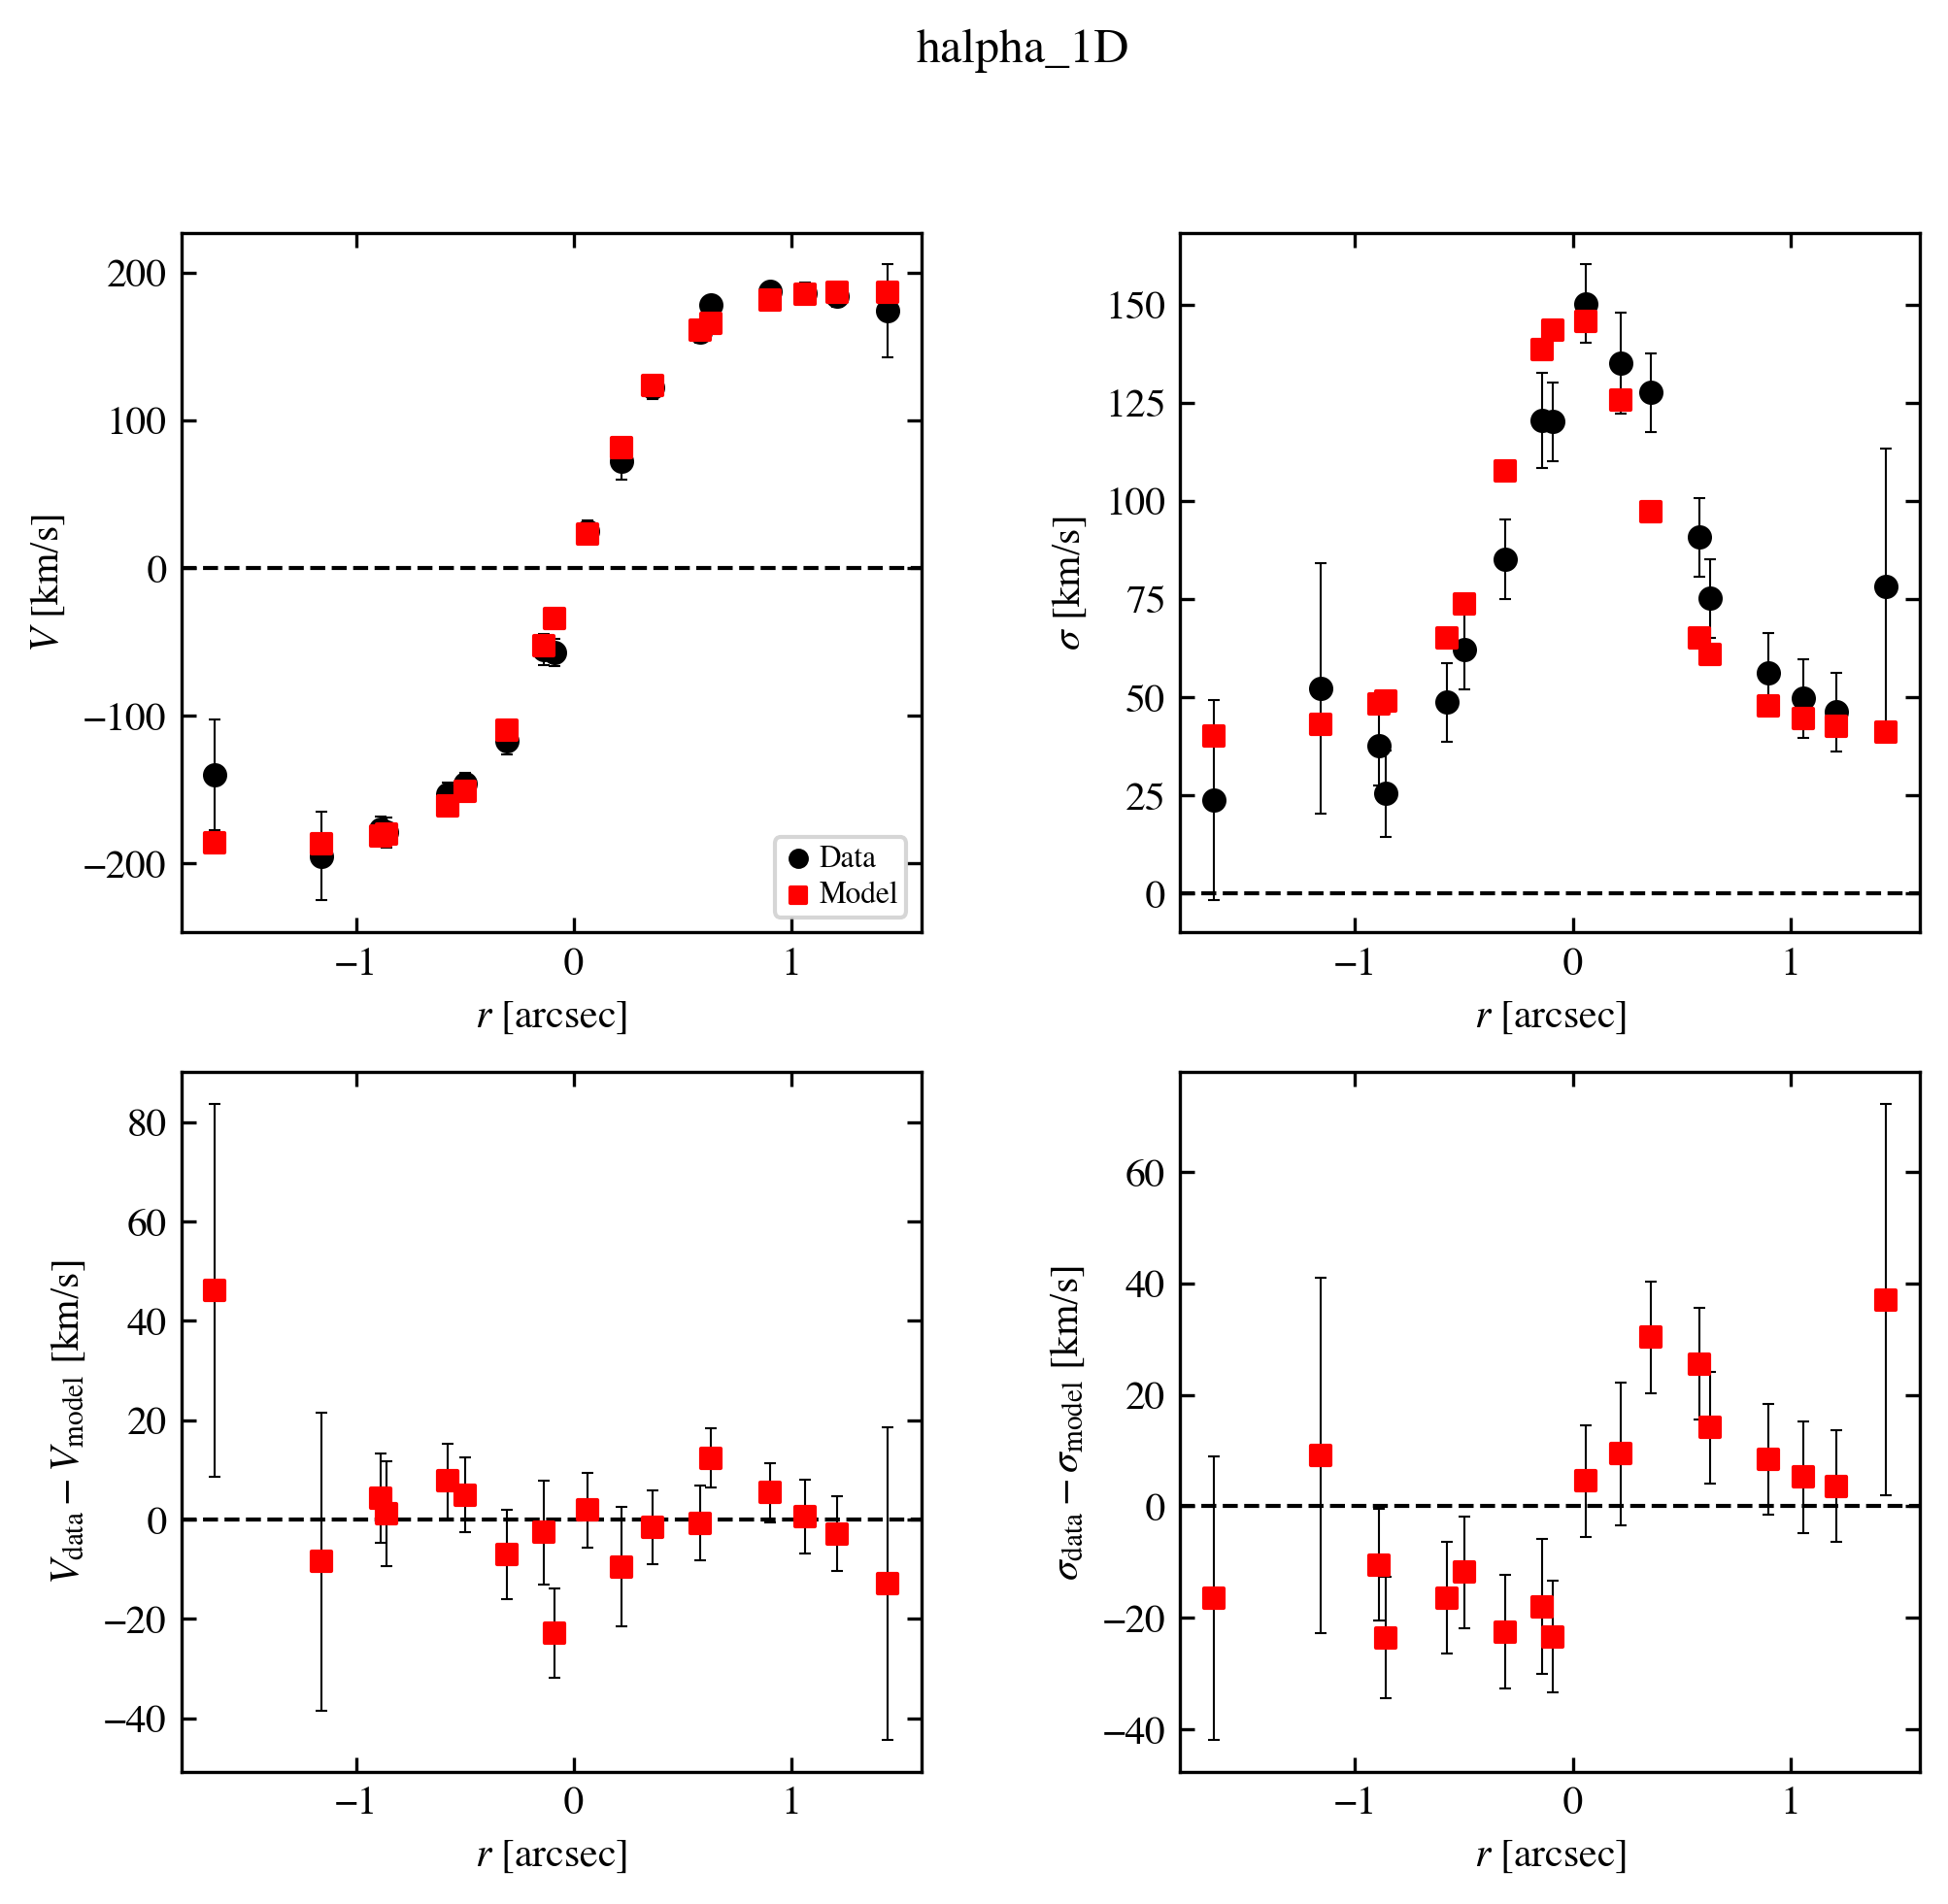

In [26]:
# Look at best-fit:
filepath = outdir_mpfit+"GS4_43501_mpfit_bestfit_halpha_1D.{}".format(plot_type)
Image(filename=filepath, width=600)

#### Directly generating result plots ####

**Reload the galaxy, results files:**

In [27]:
f_galmodel =       outdir_mpfit + 'GS4_43501_model.pickle'
f_mpfit_results =  outdir_mpfit + 'GS4_43501_mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results, fit_method='mpfit')

**Plot the best-fit results:**

In [28]:
output_options_display = output_options.copy()
output_options_display.clear_filenames()

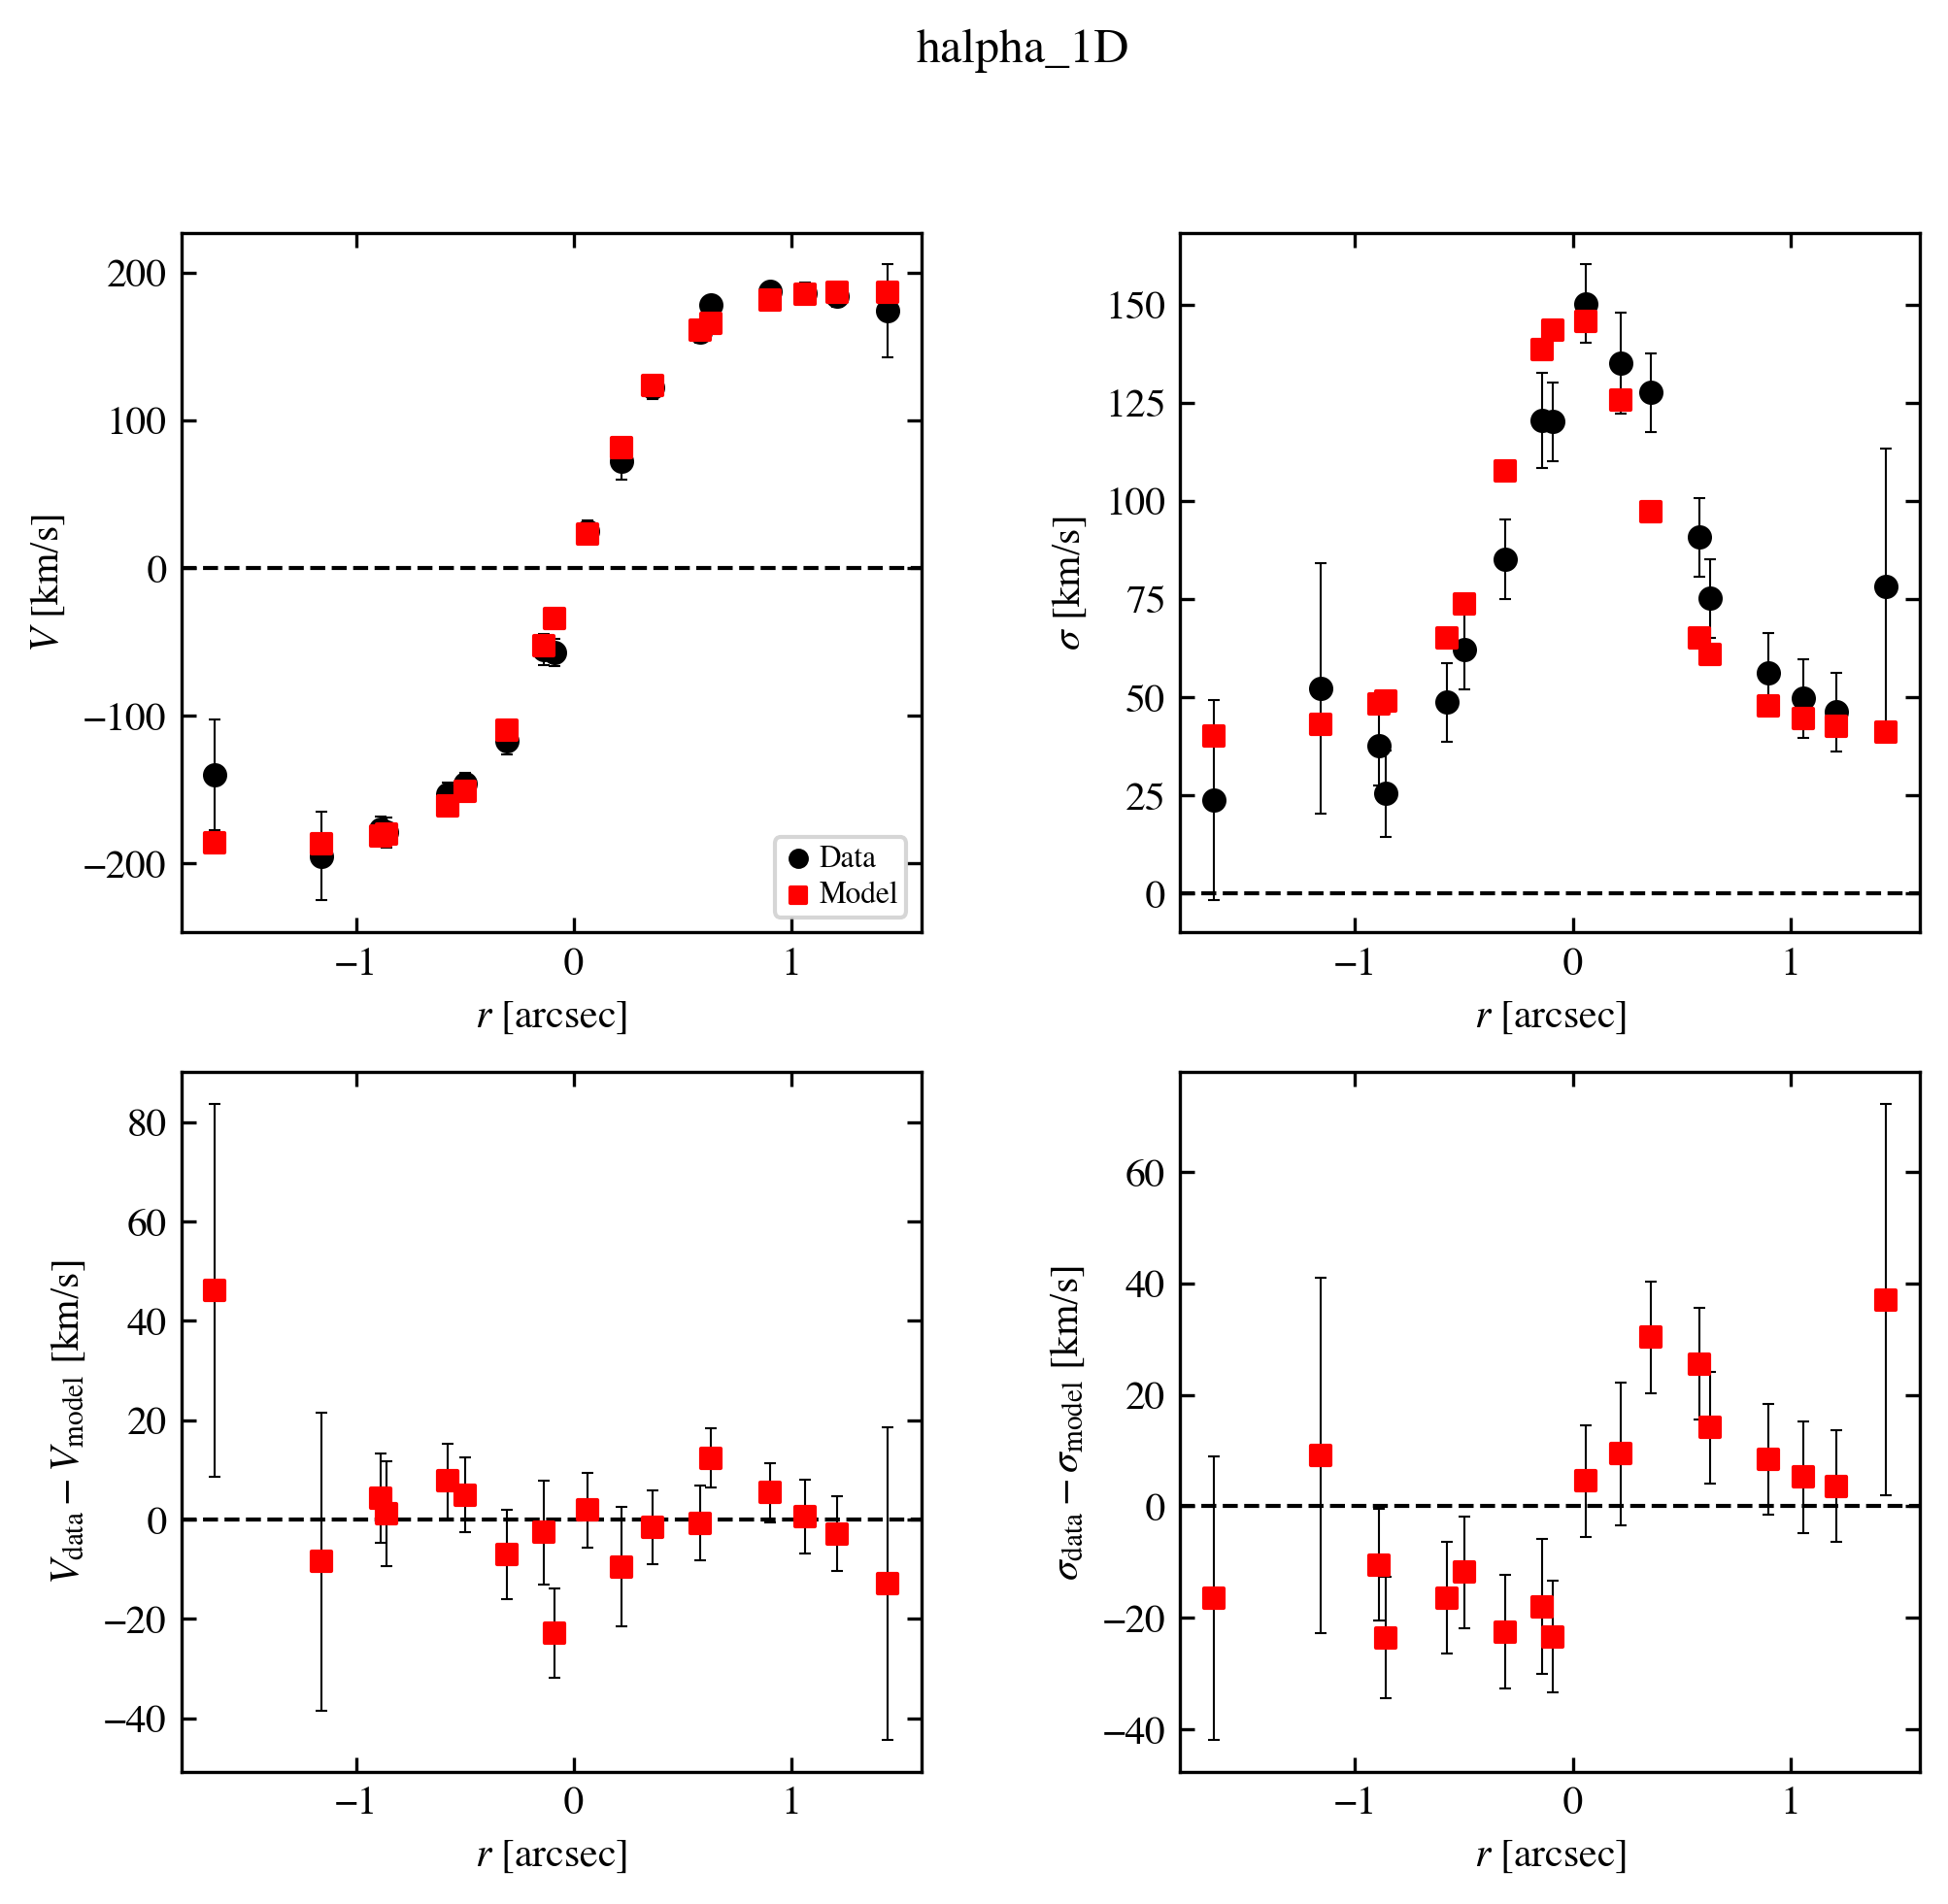

In [29]:
mpfit_results.plot_results(gal, output_options_display)

#### Result reports

We now look at the results reports, which include the best-fit values and uncertainties (as well as other fitting settings and output).

In [30]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2022-05-26 23:39:55.417220

    obs: halpha_1D
         Datafiles:
             vel :  /Users/sedona/software_public/dysmalpy/tests/test_data/GS4_43501.obs_prof.txt
         apertures:        CircApertures
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         partial_weight:        True
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1


Fitting method: MPFIT
    fit status: 1

pressure_support:      True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass         10.6801  +/-   0.0401
    r_eff_disk          2.8899  +/-   0.3327

    n_disk              1.0000  [FIXED]
    r_eff_bulge         1.0000  [FIXED]
    n_bulge             4.0000  [FIXED]
    bt                  0.3000  [FIXED]
    mass_to_light       

**To <span style="color:DarkCyan">directly save</span> the results report** to a file, we can use the following:  

(Note: by default, report files are saved as part of the fitting process)

In [31]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## MCMC Fitting

**Get a clean copy of model**

In [32]:
gal.model = copy.deepcopy(mod_set)

**Set up ``MCMCFitter`` fitter with fitting parameters**

In [33]:
# Options passed to emcee
## SHORT TEST:
nWalkers = 20
nCPUs = 4
scale_param_a = 5 #3   
# The walkers were not exploring the parameter space well with scale_param_a = 3, 
#     but were getting 'stuck'. So to improve the walker movement with larger 
#     'stretch' in the steps, we increased scale_param_a.
nBurn = 2
nSteps = 5
minAF = None
maxAF = None
nEff = 10

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step


fitter = fitting.MCMCFitter(nWalkers=nWalkers, nCPUs=nCPUs, 
                            scale_param_a=scale_param_a, nBurn=nBurn, nSteps=nSteps, 
                            minAF=minAF, maxAF=maxAF, nEff=nEff, blob_name=blob_name)

**Set up fit/plot output options**

In [34]:
# Output directory
outdir_mcmc = outdir + 'MCMC/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mcmc, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MCMC**

In [35]:
mcmc_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:    obs: halpha_1D
INFO:DysmalPy:        velocity file: /Users/sedona/software_public/dysmalpy/tests/test_data/GS4_43501.obs_prof.txt
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 20
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x1349a97e0>
INFO:DysmalPy:
Burn-in:
Start: 2022-05-26 23:39:56.108779

INFO:DysmalPy: k=0, time.time=2022-05-26 23:39:56.114681, a_frac=nan
INFO:DysmalPy: k=1, time.time=2022-05-26 23:41:14.852936, a_frac=0.15
INFO:DysmalPy:
End: 2022-05-26 23:41:17.377315

******************
nCPU, nParam, nWalker, nBurn = 4, 4, 20, 2
Scale param a= 5
Time= 81.26 (sec),   1:21.26 (m:s)
Mean acceptance fraction: 0.150
Ideal acceptance frac: 0.2 - 0.5
Autocorr est: [nan nan nan nan]
******************
INFO:DysmalPy:
#################
acorr time un

### Examine MCMC results

Of course this (very short!) example looks terrible, but it's instructive to see what's happening even if you only did a very short / few walker MCMC test:

**Trace**
- The individual walkers should move around in the parameter space over the chain iterations (not necessarily for every step; but there should be ***some*** exploration of the space)

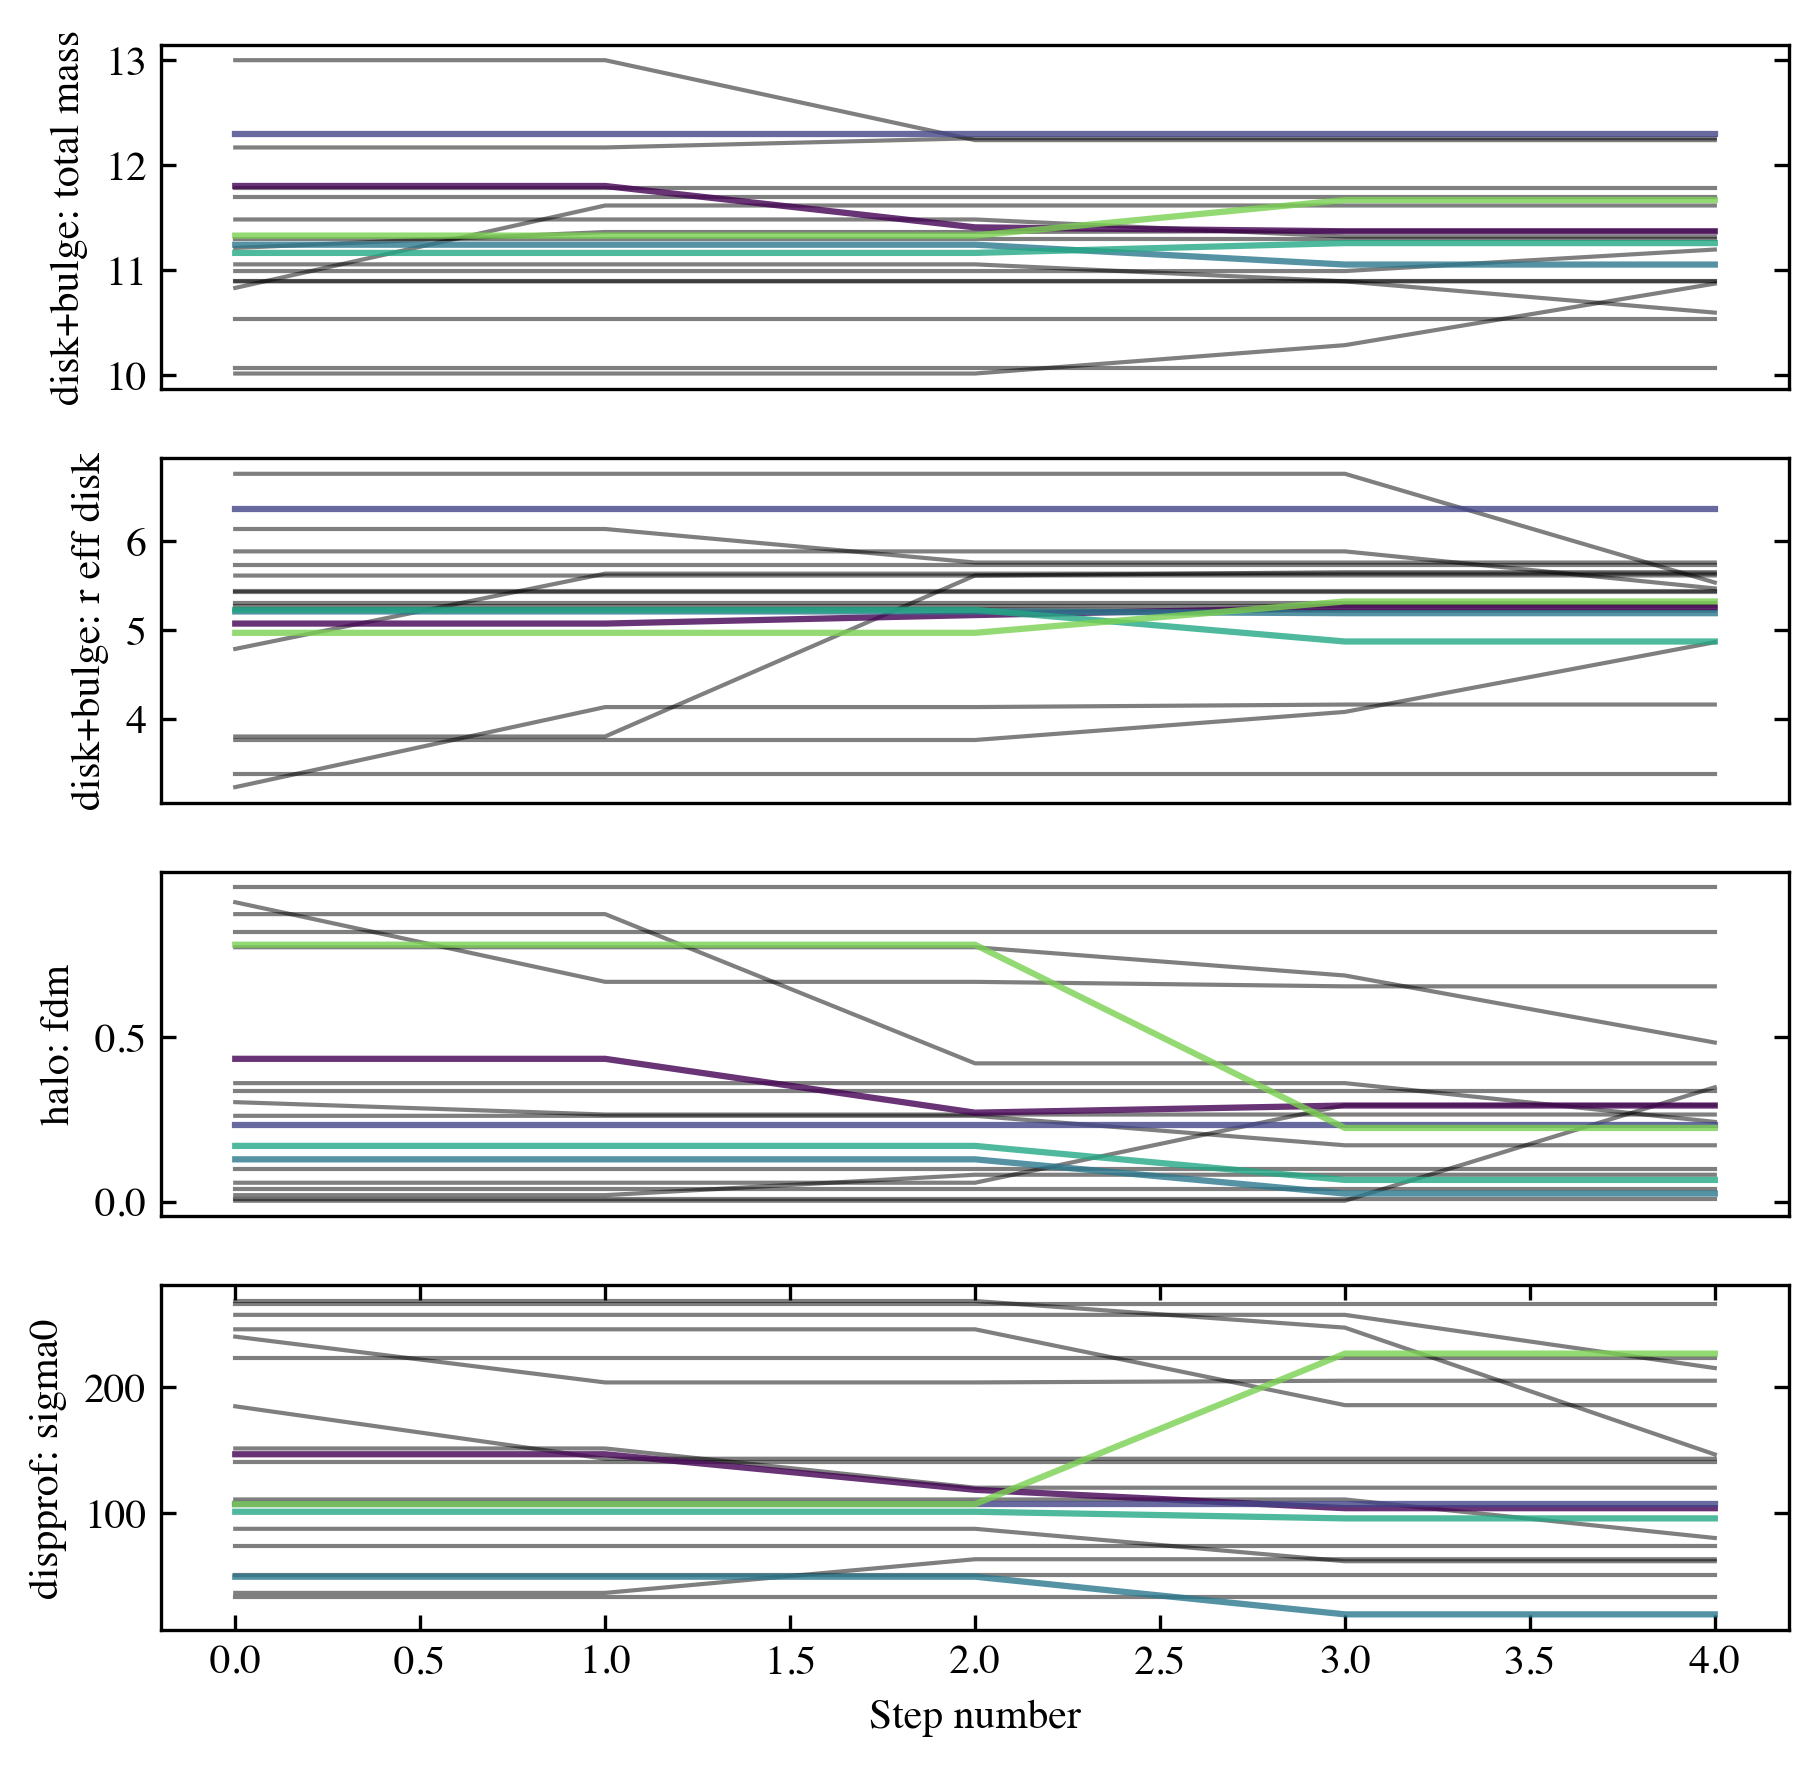

In [36]:
# Look at trace:
filepath = outdir_mcmc+"GS4_43501_mcmc_trace.{}".format(plot_type)
Image(filepath, width=600)

**Best-fit**
- This is a good opportunity to check that the model PA and slit PA are correct, or else the data and model curves will have opposite shapes!

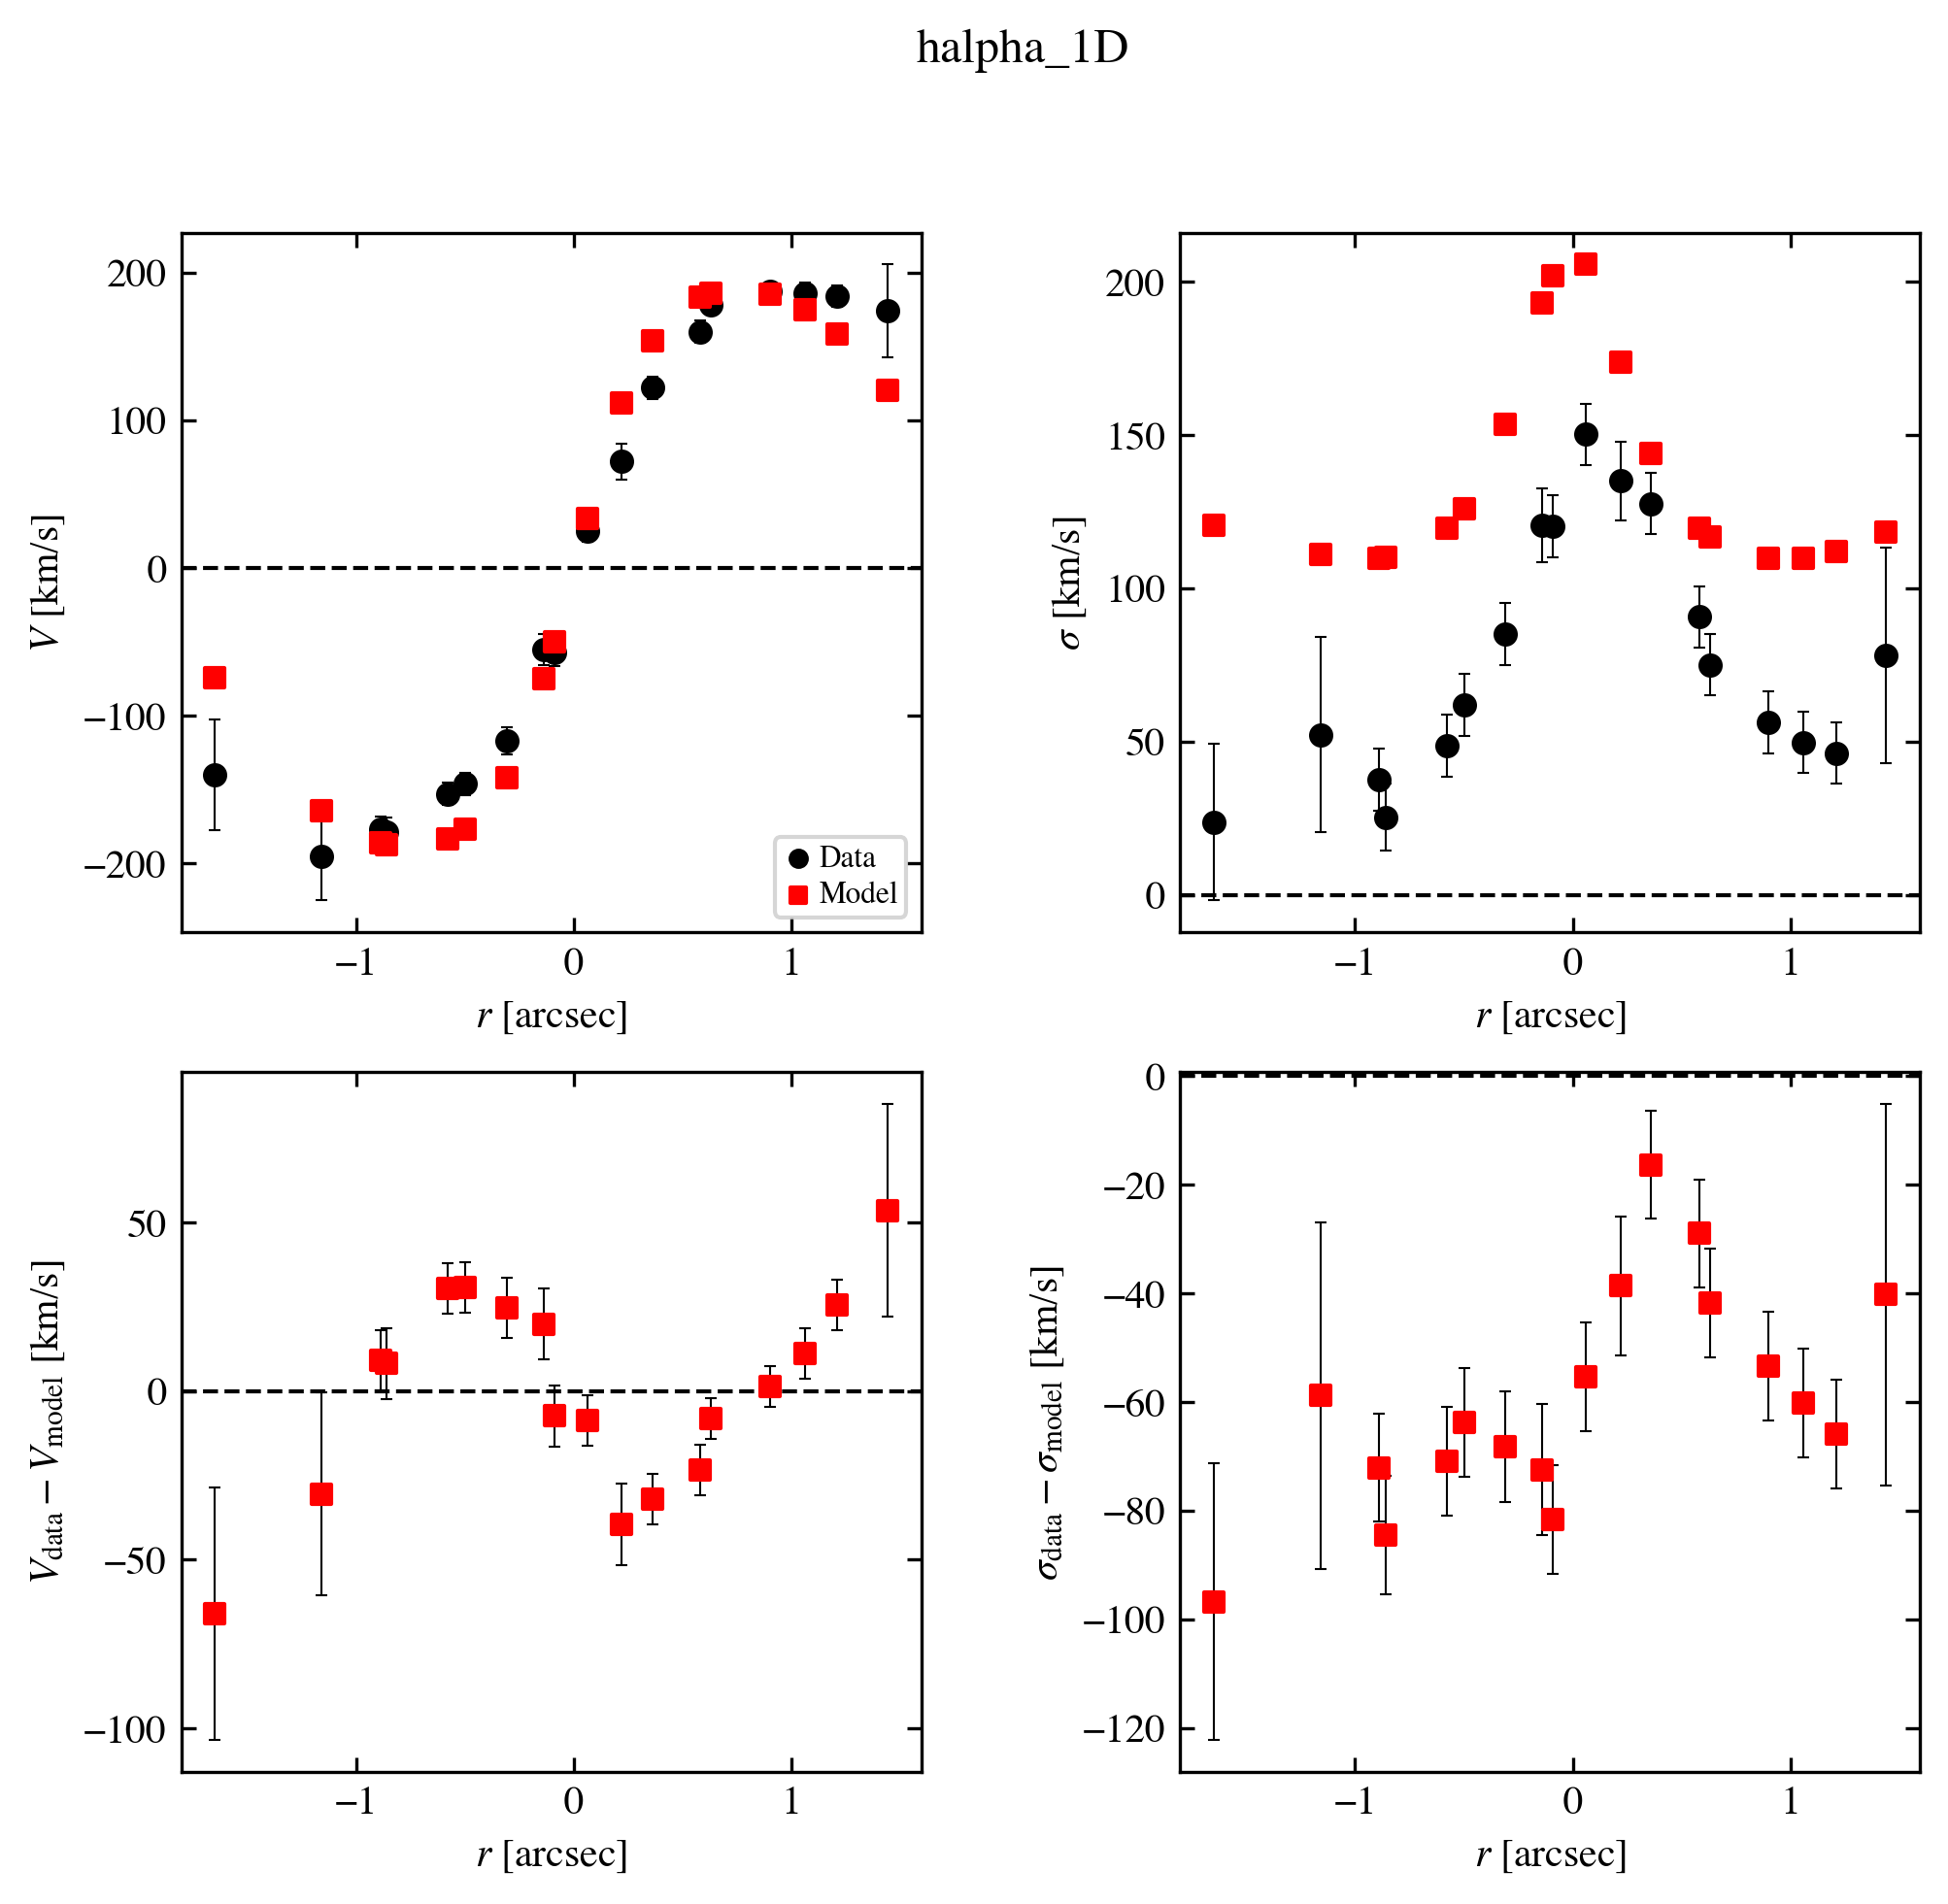

In [37]:
# Look at best-fit:
filepath = outdir_mcmc+"GS4_43501_mcmc_bestfit_halpha_1D.{}".format(plot_type)
Image(filepath, width=600)

**Sampler "corner" plot**
- The "best-fit" MAP (by default taken to be the peak of each marginalized parameter posterior, independent of the other parameters) is marked with the solid blue line. 
  * However, the MAP can also be found by jointly analyzing two or more parameters' posterior space (see example below).
- Check to see that your Gaussian prior centers are marked in orange in the appropriate rows/columns (if any Gaussian priors are used).
- The vertical dashed black lines show the 2.275%, 15.865%, 84.135%, 97.725% percentile intervals for the marginalized posterior for each parameter. 
- The vertical dashed purple lines show the shortest $1\sigma$ interval, determined from the marginalized posterior for each parameter independently. 

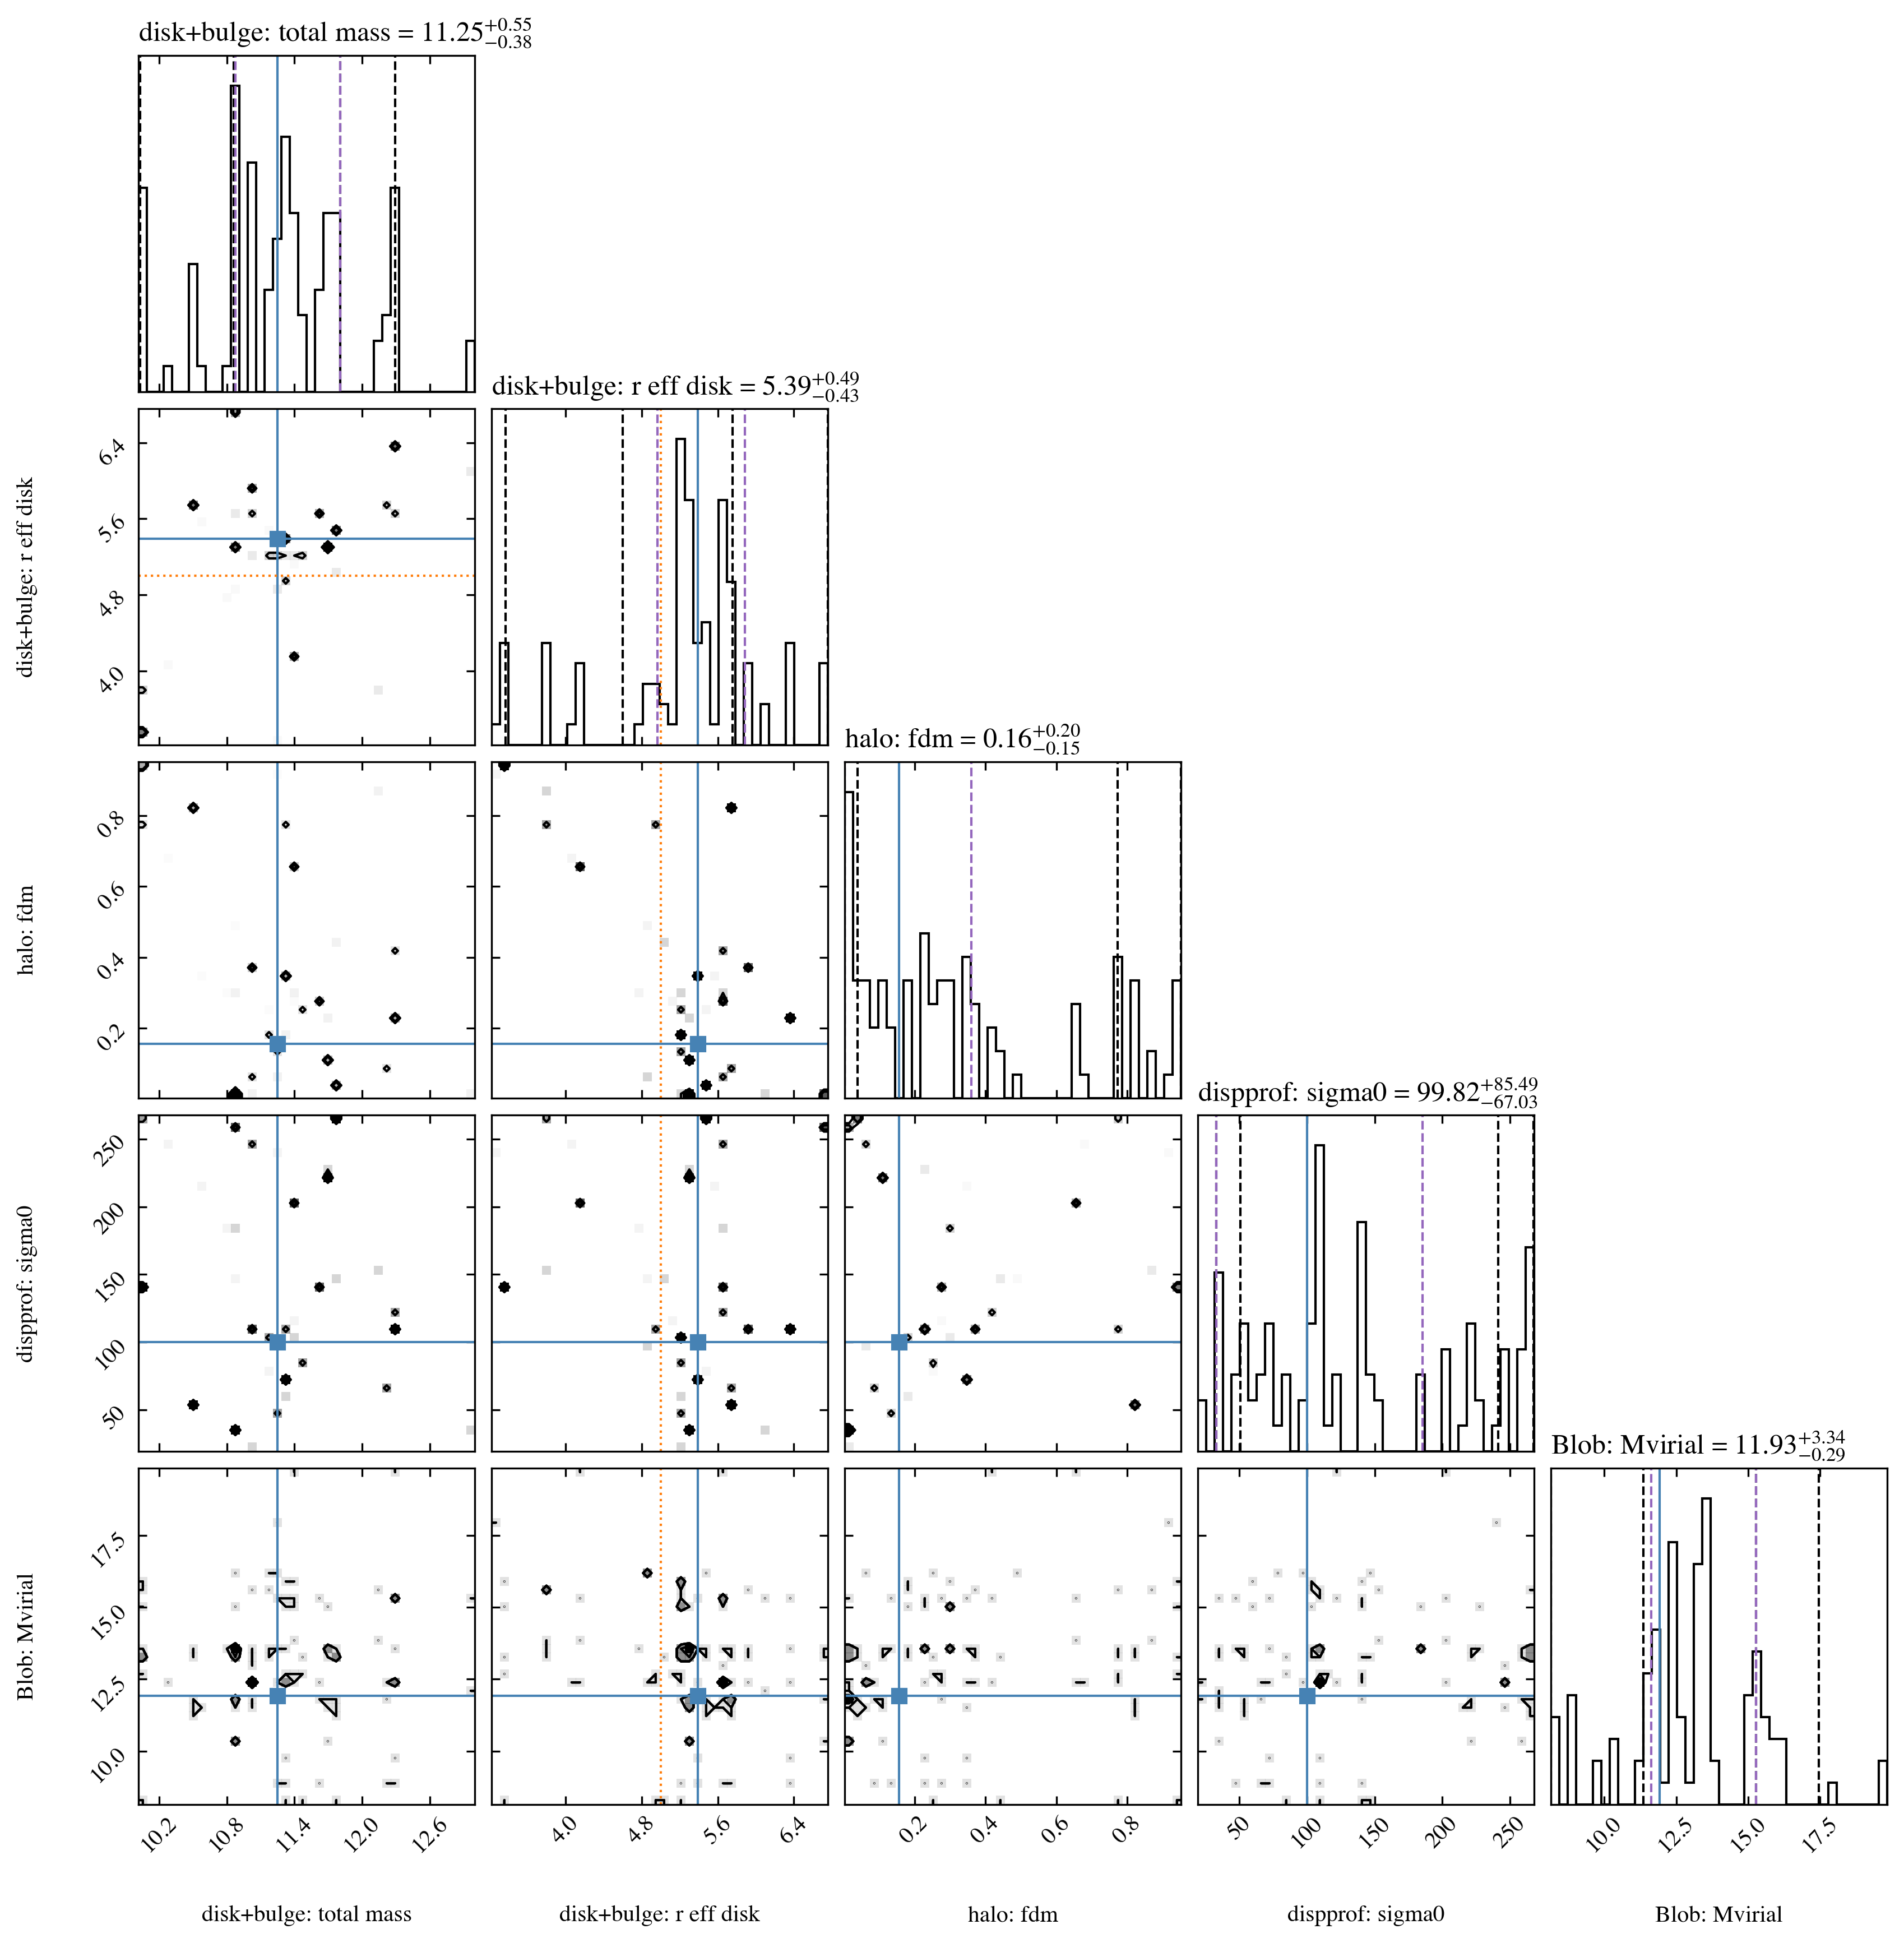

In [38]:
# Look at corner:
filepath = outdir_mcmc+"GS4_43501_mcmc_param_corner.{}".format(plot_type)
Image(filepath, height=620)

---------

## A real MCMC example

In the interest of time, let's look at some results calculated previously.

For this fit, we used 1000 walkers, 50 burn-in steps, and 200 steps. 

Using **190 threads**, it took about **23 minutes** to run the MCMC fit.

In [39]:
outdir_mcmc_full = outdir + 'MCMC_full_run_nw1000_ns200_a5/'

### Examine results: ###


Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

**Reload the galaxy, results files:**

In [40]:
f_galmodel =      outdir_mcmc_full + 'galaxy_model.pickle'
f_mcmc_results =  outdir_mcmc_full + 'mcmc_results.pickle'

#----------------------------------------
## Fix module import
import sys
from dysmalpy import fitting_wrappers
sys.modules['fitting_wrappers'] = fitting_wrappers
#----------------------------------------

gal, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mcmc_results, fit_method='mcmc')

**If necessary, also reload the sampler chain:**

In [41]:
f_sampler =  outdir_mcmc_full + 'mcmc_sampler.{}'.format(ftype_sampler)
mcmc_results.reload_sampler(filename=f_sampler)

**Plot the best-fit results:**

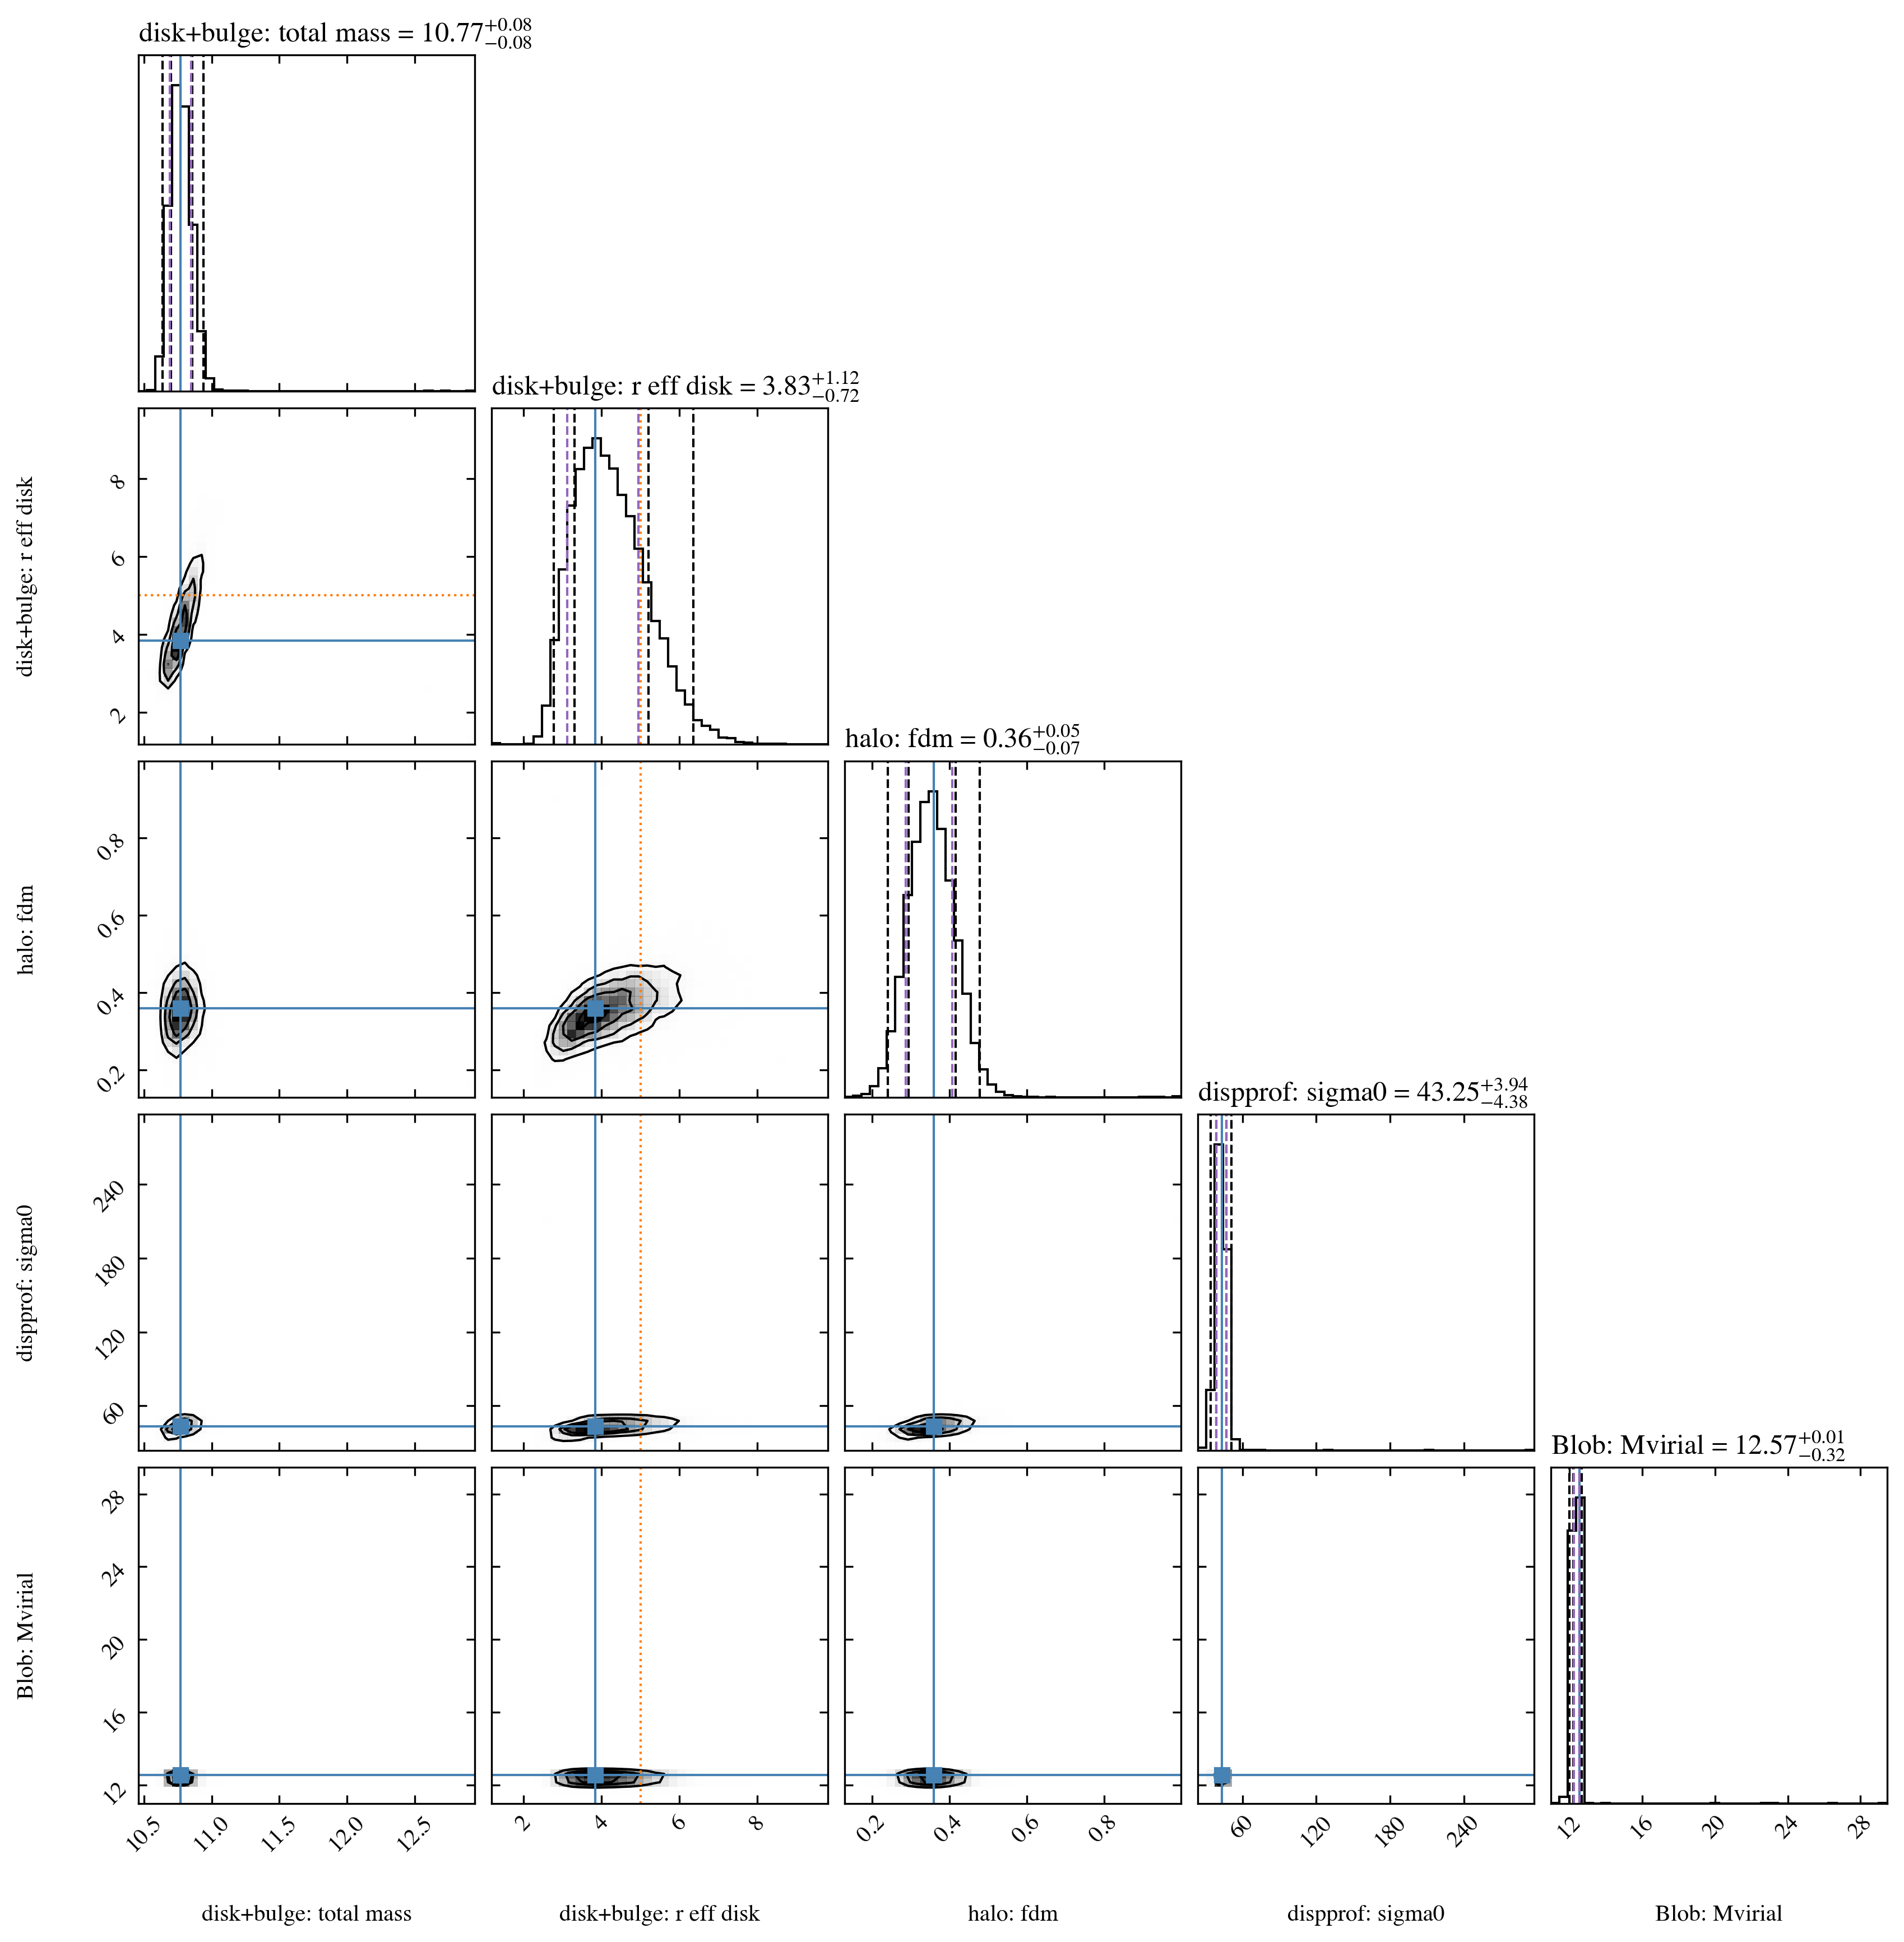

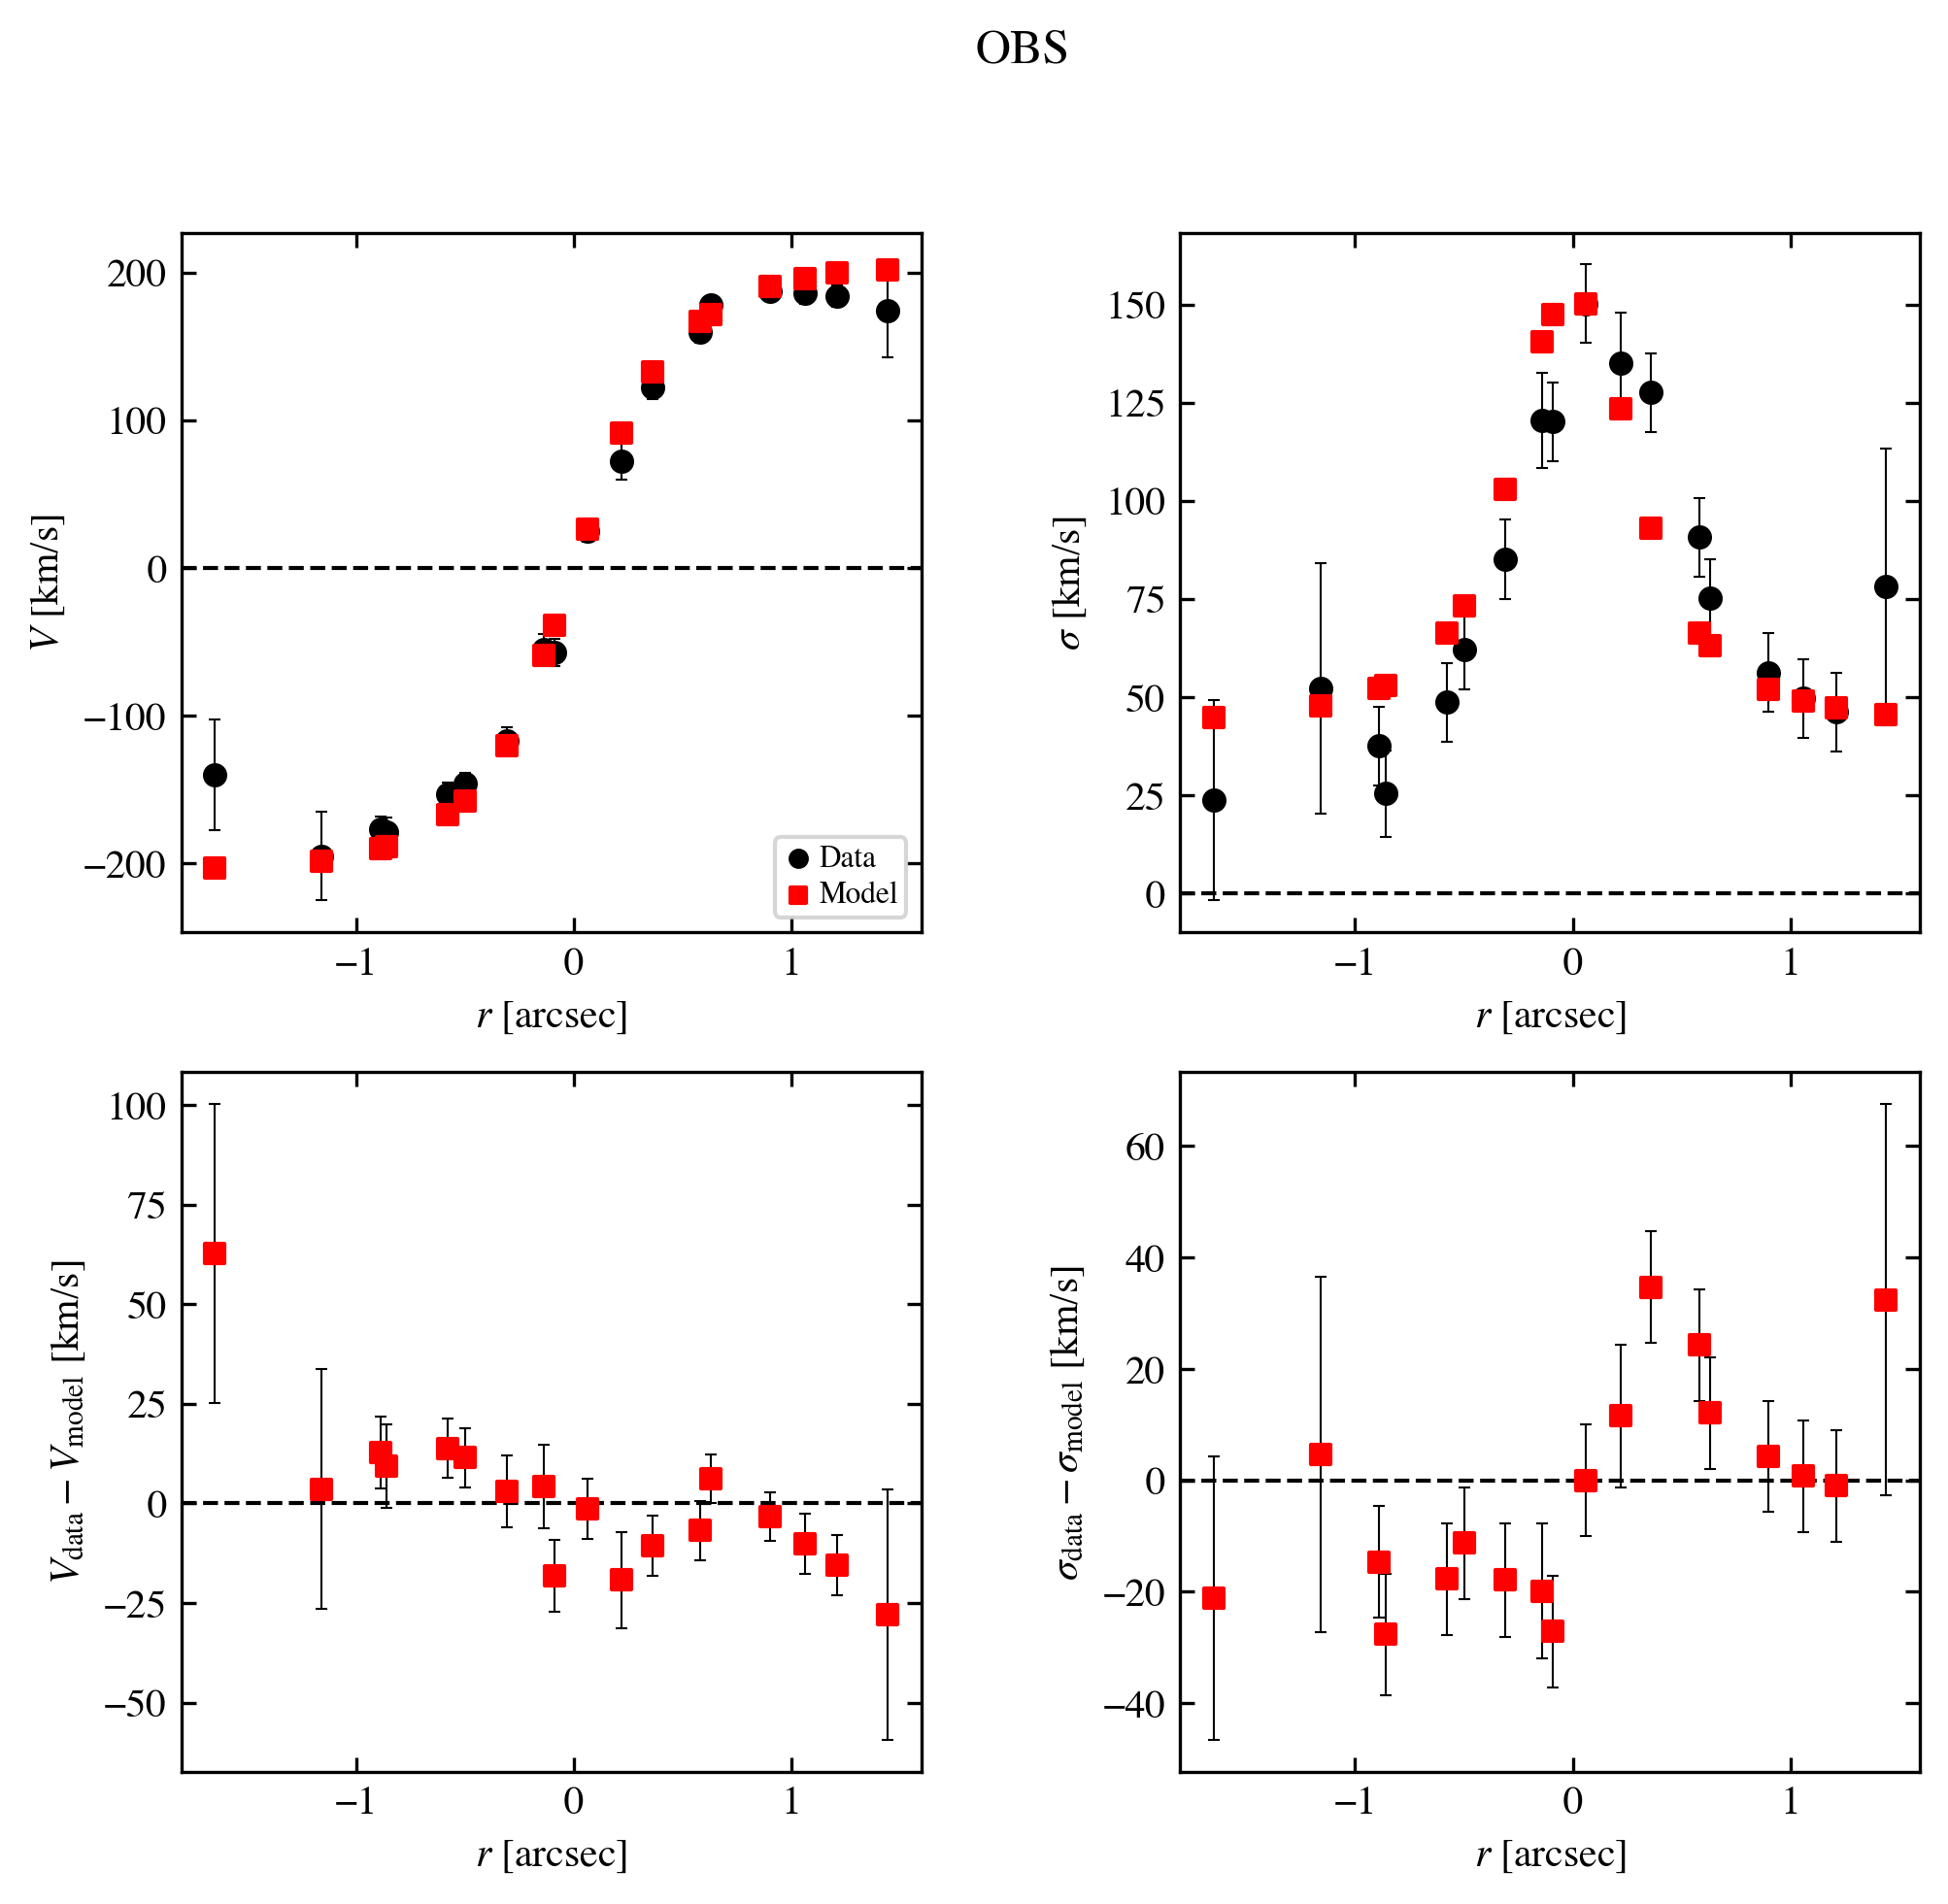

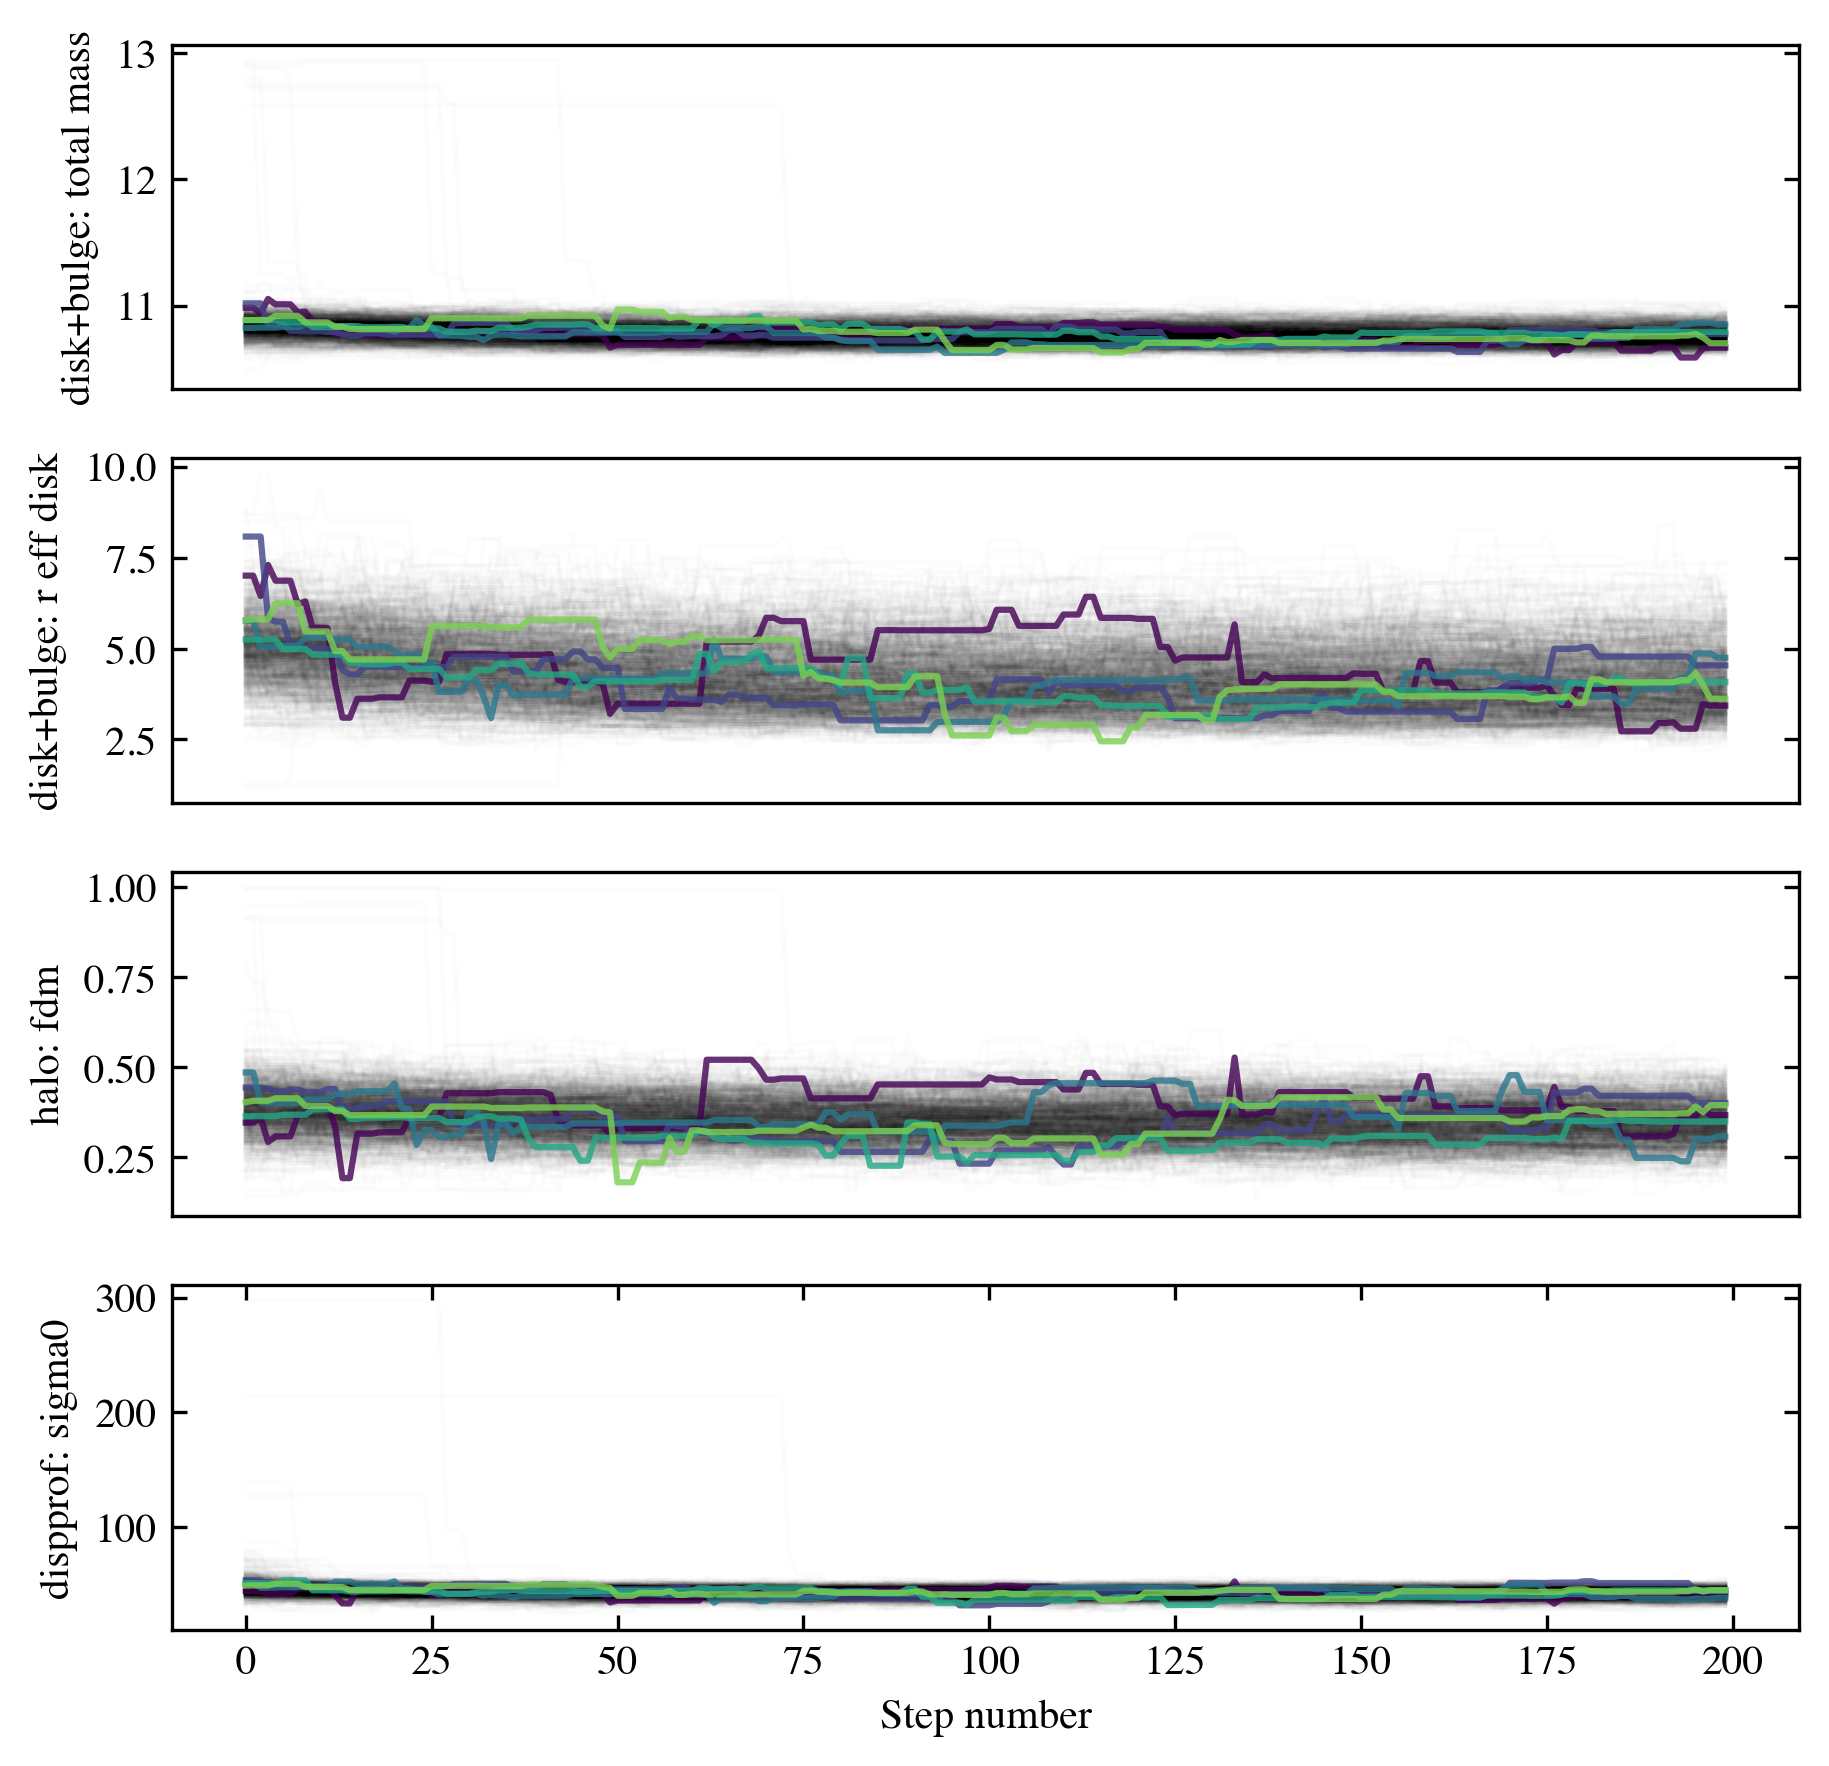

In [42]:
mcmc_results.plot_results(gal)

In [43]:
# %debug

:::{admonition} Note:
The burn-in stage for this run is probably a bit too short, 
as the trace for ``r_eff_disk`` drifts a bit initially. 
So it might have been better to use 100 burn steps (50 were used here).
:::

#### Results report: ####

In [44]:
# Print report
print(mcmc_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2022-05-26 23:41:47.220717

    obs: OBS
         Datafiles:
             vel :  /afs/mpe.mpg.de/home/sedona/dysmalpy_example_data/GS4_43501.obs_prof.txt
         apertures:        CircApertures
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         partial_weight:        True
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1


Fitting method: MCMC

pressure_support:      True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass         10.7707  -   0.0797 +   0.0770
    r_eff_disk          3.8296  -   0.7181 +   1.1167

    n_disk              1.0000  [FIXED]
    r_eff_bulge         1.0000  [FIXED]
    n_bulge             4.0000  [FIXED]
    bt                  0.3000  [FIXED]

    noord_flat          True
------

**Or save results report to file:**

In [45]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
mcmc_results.results_report(gal=gal, filename=f_mcmc_report)

-------------

### *Optional*: Reanalyze sampler for MAP using joint posterior spaces for some parameters

In [46]:
# Look at joint posterior of 4 parameters simultaneously:
#       total baryonic mass, r_eff_disk, fDM, sigma0

# Create a list / an array containing each parameter to include:
linked_post_arr = []
# For each parameter, include a length 2 list / array 
#     with the component name and parameter name:
linked_post_arr.append(['disk+bulge', 'total_mass'])
linked_post_arr.append(['disk+bulge', 'r_eff_disk'])
linked_post_arr.append(['halo', 'fdm'])
linked_post_arr.append(['dispprof', 'sigma0'])


# Only consider 1 bundle of joint posteriors:
linked_posterior_names = [ linked_post_arr ]

In [47]:
# Then rerun the posterior distribution analysis, using this linked posterior set:
mcmc_results.linked_posterior_names = linked_posterior_names 

mcmc_results.analyze_posterior_dist(gal=gal)

In [48]:
# Update theta to best-fit:
gal.model.update_parameters(mcmc_results.bestfit_parameters)

In [49]:
# Recalculate the bestfit chisq / redchisq:
gal.create_model_data()

mcmc_results.bestfit_redchisq = fitting.chisq_red(gal)
mcmc_results.bestfit_chisq = fitting.chisq_eval(gal)

**Result report for this re-analysis:**

In [50]:
# Print report
print(mcmc_results.results_report(gal=gal))

###############################
 Fitting for GS4_43501

Date: 2022-05-26 23:41:51.324034

    obs: OBS
         Datafiles:
             vel :  /afs/mpe.mpg.de/home/sedona/dysmalpy_example_data/GS4_43501.obs_prof.txt
         apertures:        CircApertures
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         partial_weight:        True
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1


Fitting method: MCMC

pressure_support:      True
pressure_support_type: 1

###############################
 Fitting results
-----------
 disk+bulge
    total_mass         10.7489  -   0.0578 +   0.0989
    r_eff_disk          3.8097  -   0.6982 +   1.1366

    n_disk              1.0000  [FIXED]
    r_eff_bulge         1.0000  [FIXED]
    n_bulge             4.0000  [FIXED]
    bt                  0.3000  [FIXED]

    noord_flat          True
------

**Best-fit results plot for this reanalysis:**

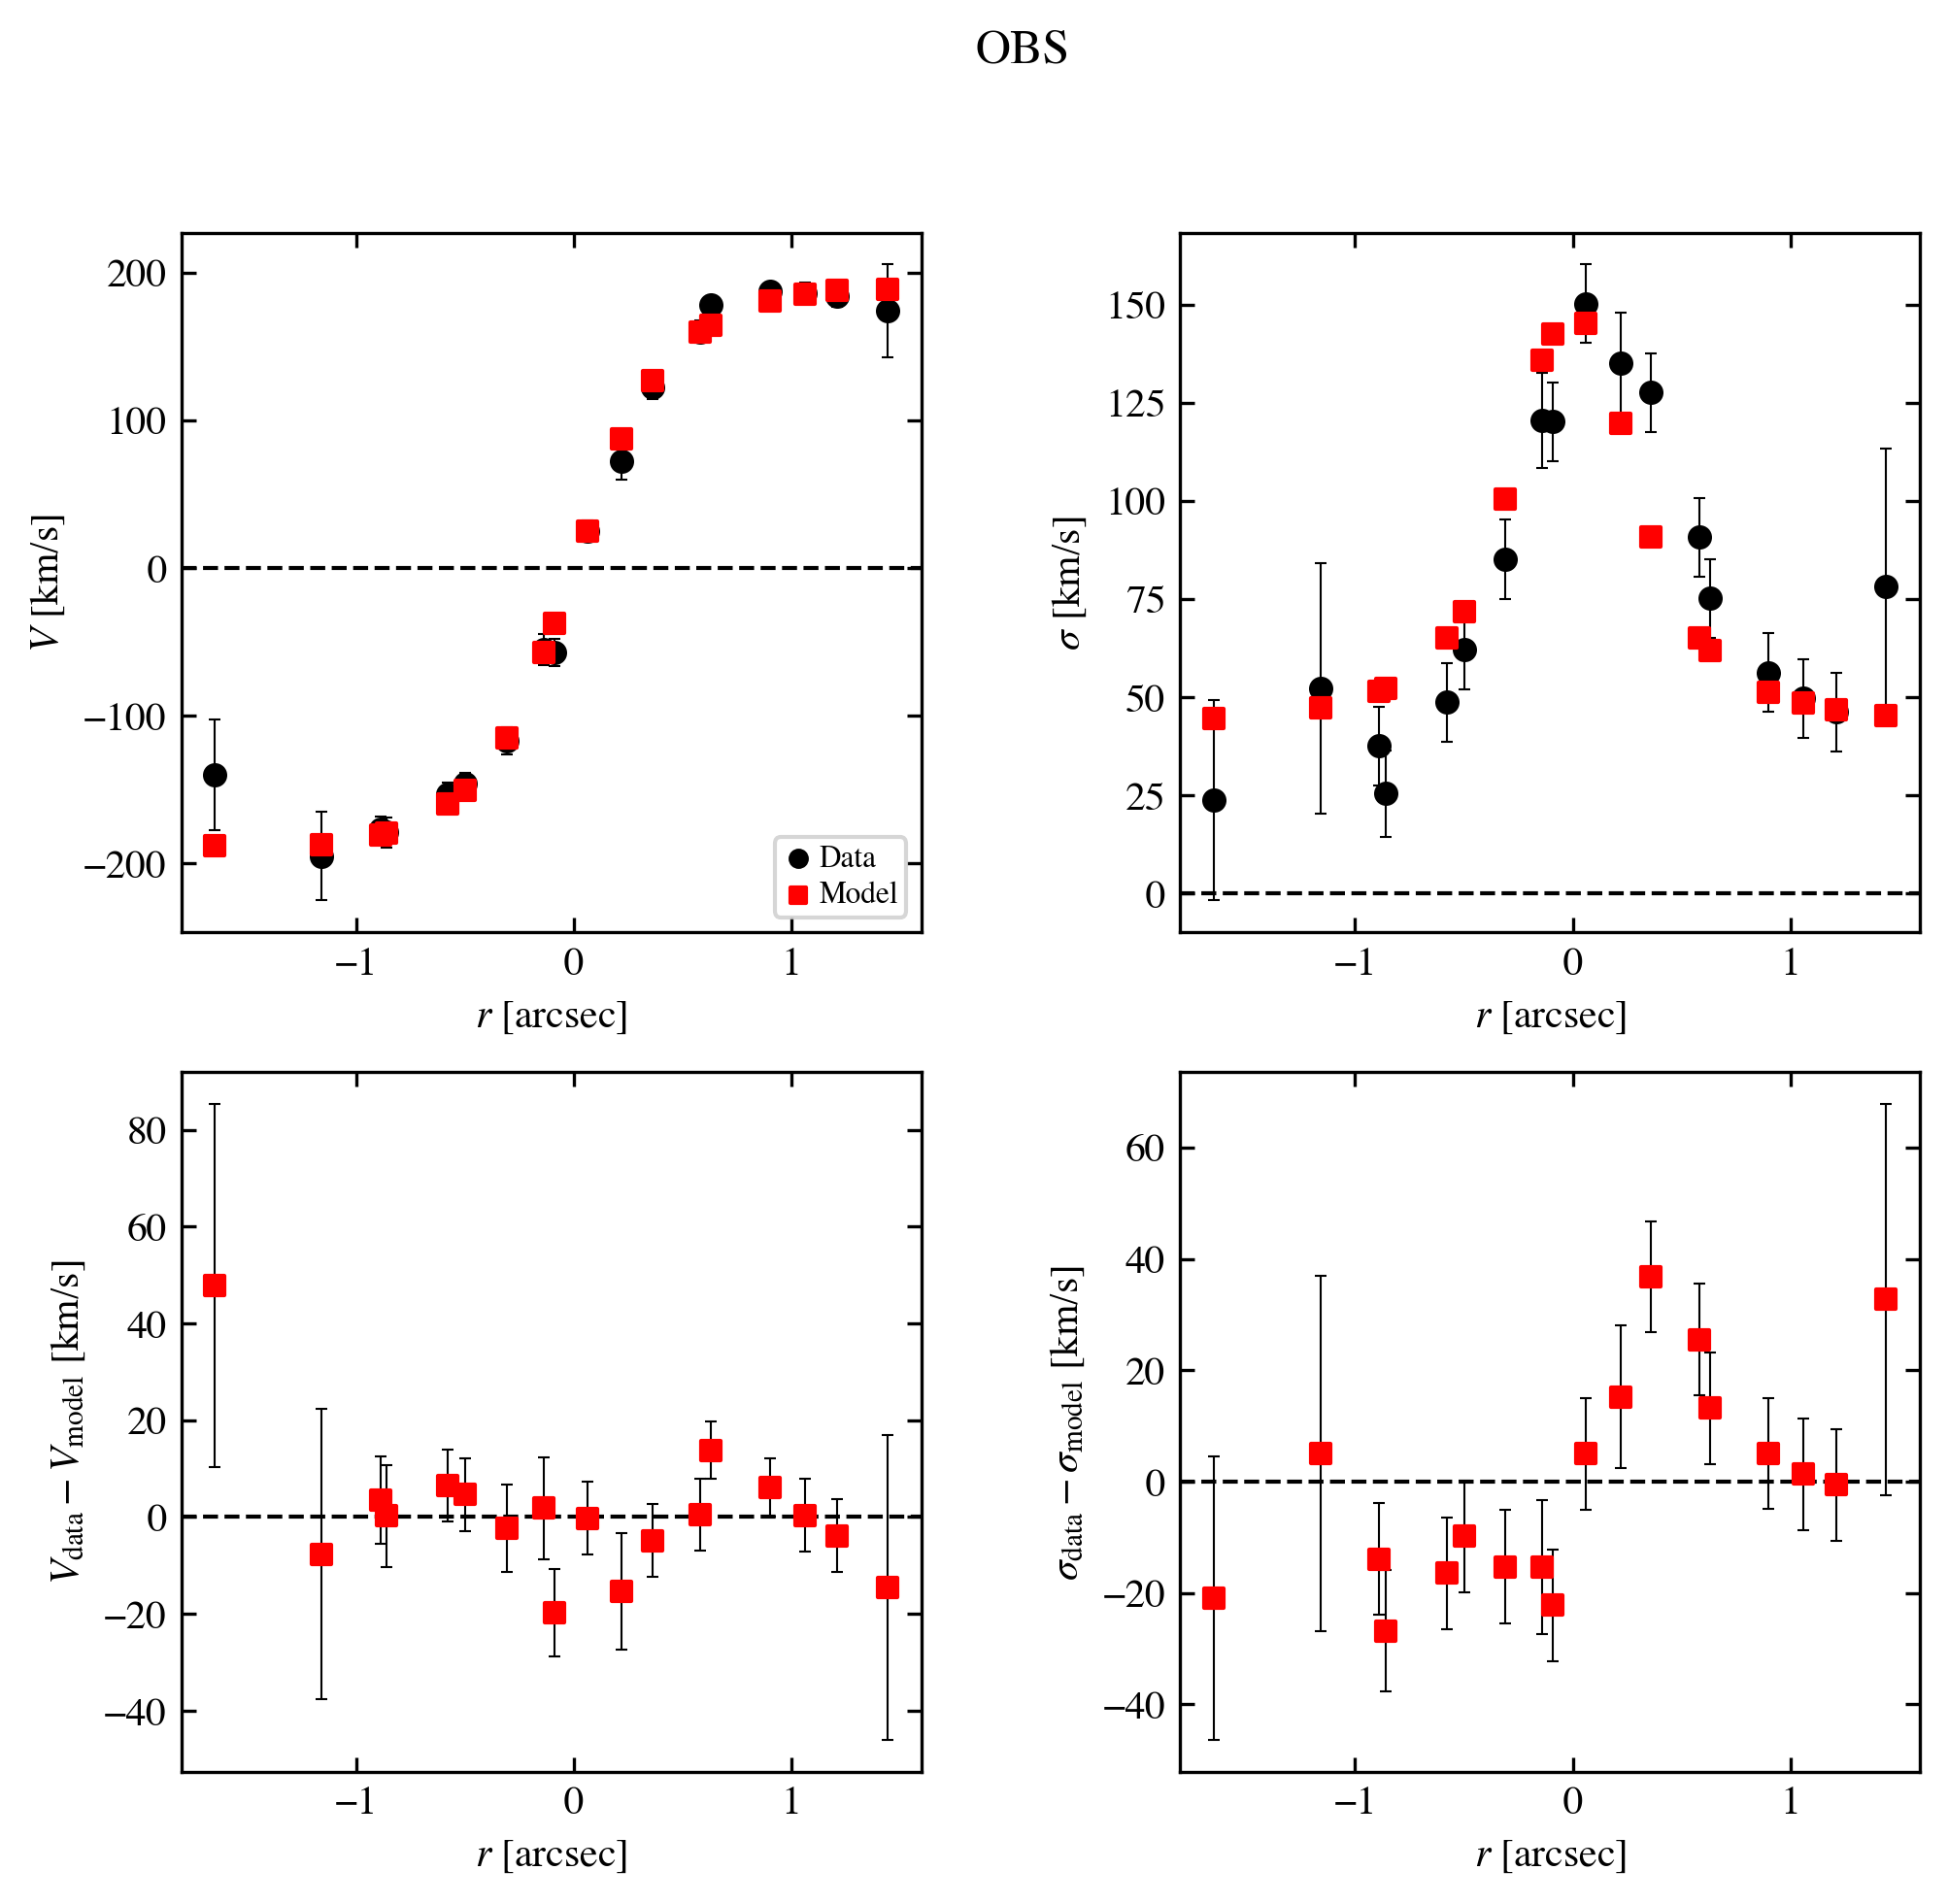

In [51]:
mcmc_results.plot_bestfit(gal)

**Posterior distribution showing this new joint-posterior MAP:**

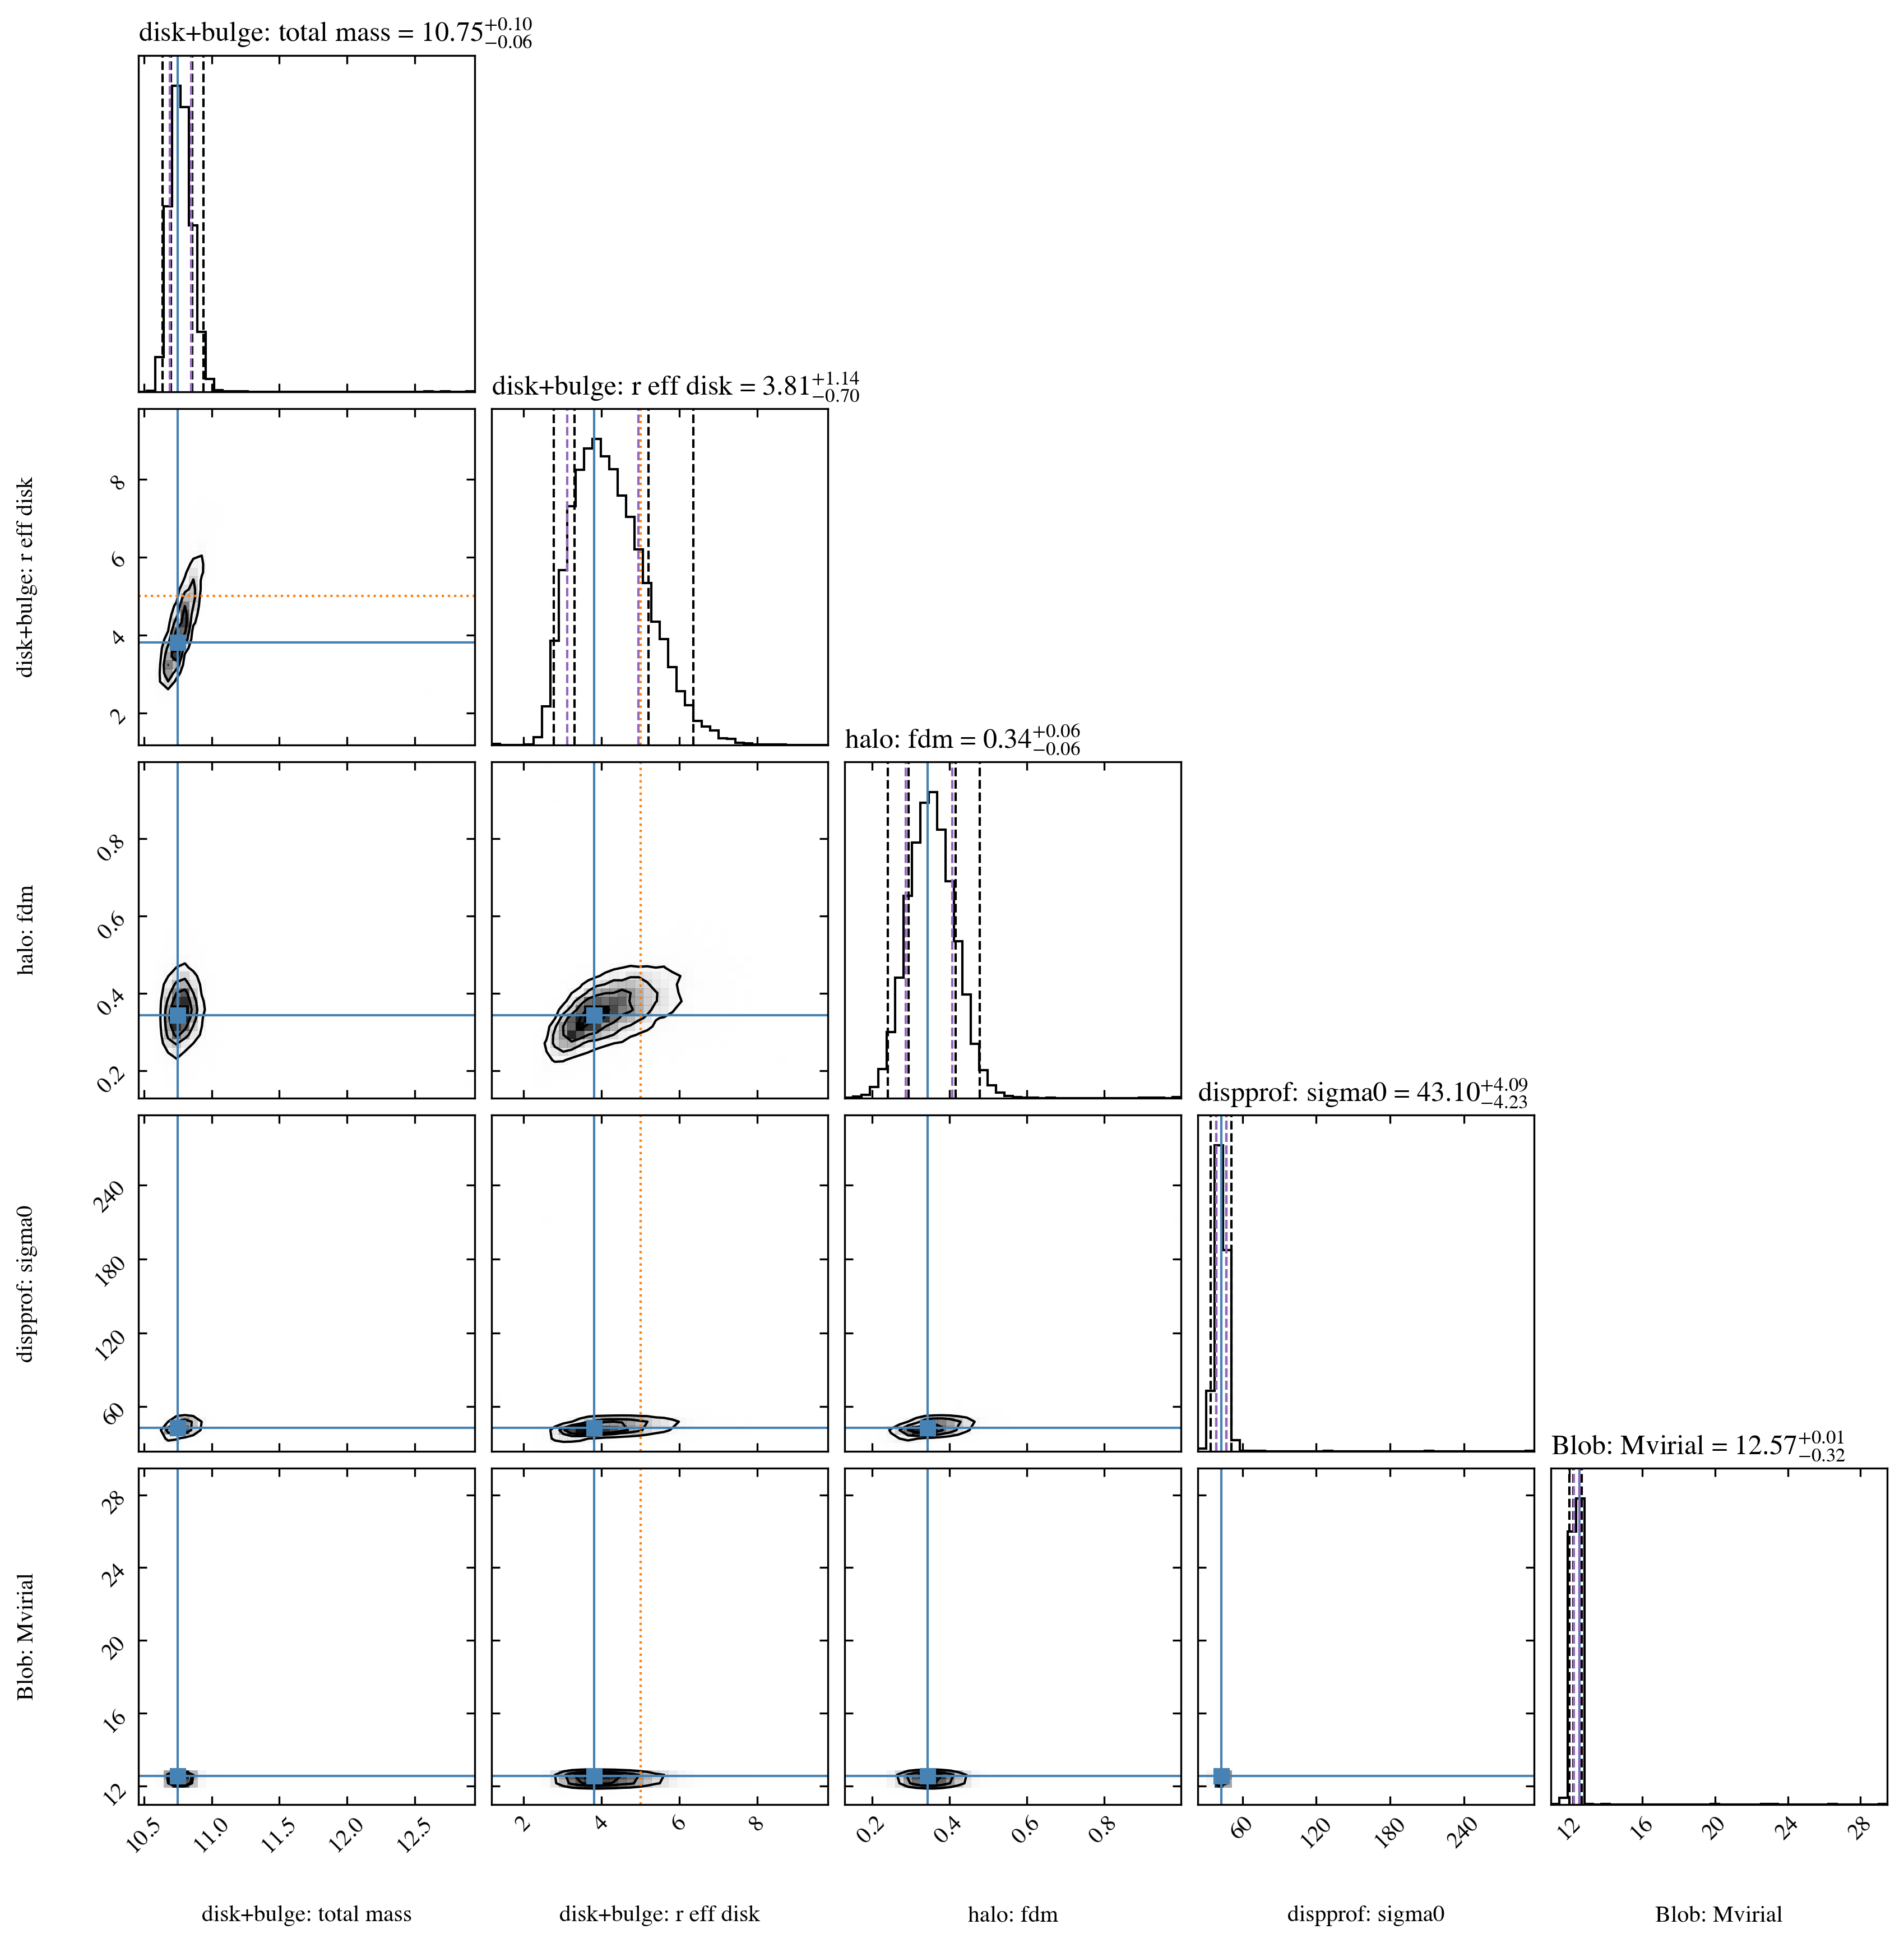

In [52]:
mcmc_results.plot_corner(gal)